# Deep Learning Based Automatic Feature Extraction for Network Intrusion Detection System
<br>

## Project

This research study proposes a combination of a deep learning technique and an ensemble model approach for detecting network intrusion attacks. In specific, we propose to focus on unsupervised pre-training using autoencoder for effective feature extraction from network traffic data. Our proposed NIDS model will consist of a stacked autoencoder which will extract useful latent features hidden in network traffic flow records, and then feed those in to an Stacking ensemble classifier which will detect and separate network attack traffic from normal traffic.
<br>

## DataSet 

https://research.unsw.edu.au/projects/unsw-nb15-dataset

A partition from this dataset was configured as a training set and testing set, namely, UNSW_NB15_training-set.csv and UNSW_NB15_testing-set.csv respectively, by the creators of this dataset. The number of records in the training set is 175,341 records and the testing set is 82,332 records from the different types, attack and normal.
<br>

## Execution Steps

###  1. Load Dataset and Examine the features
###  2. Basic Pre-processing - Missing Values, Outliers Treatment etc.
###  3. Data Preparation For Modelling

#####     3.1 Check class imbalance
#####     3.2 Transformation (One-hot encoding) of categorical variables
#####     3.3 Split original dataset in to Train-Test data
#####     3.4 Standard Scaling of Features

###  4. Modelling

###     4.1 Auto Encoder
#####       4.1.1 Training AutoEncoder
#####          4.1.1.1 Hyper-Parameter Tuning of Auto Encoder
#####          4.1.1.2 Fit AutoEncoder
#####       4.1.2 Verify AutoEncoder
#####       4.1.3 Extract Features Using AutoEncoder


###    4.2 Stacking Classifier Model

#####      4.2.1 Base Models 
#####         4.2.1.1 Base Model-1 ( Support Vector Machine Classifier )
#####       4.2.1.2 Base Model-2 ( Random Forest Classifier )
#####       4.2.1.3 Base Model-3 (XGBoost Classifier)

#####      4.2.2 Stacking Blender Model (Logistic Regression Classifier)

### 5. Final Whole Model Validation
###  6. Conclusion <br>

#### Import essential libraries and packages

In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


#### Helper Methods Used For Various Purposes 

In [69]:
# create plotting functions
import matplotlib.pyplot as plt
import seaborn as sns

def data_type(variable):
    if variable.dtype == np.int64 or variable.dtype == np.float64 or variable.dtype == np.uint8:
        return 'numerical'
    elif variable.dtype == 'category':
        return 'categorical'
    
def univariate(variable, stats=True):
    
    if data_type(variable) == 'numerical':
        sns.distplot(variable)
        if stats == True:
            print(variable.describe())
    
    elif data_type(variable) == 'categorical':
        sns.countplot(variable)
        if stats == True:
            print(variable.value_counts())
            
    else:
        print("Invalid variable passed: either pass a numeric variable or a categorical vairable.")
        
def bivariate(var1, var2):
    if data_type(var1) == 'numerical' and data_type(var2) == 'numerical':
        sns.regplot(var1, var2)
    elif (data_type(var1) == 'categorical' and data_type(var2) == 'numerical') or (data_type(var1) == 'numerical' and data_type(var2) == 'categorical'):        
        sns.boxplot(var1, var2)

In [109]:
#### Function to print confusion matrix, accuracy, sensitivity, FPR, precision, specificity etc

def print_binary_classification_summary(y, y_pred):
    
    confusion = metrics.confusion_matrix(y, y_pred)
    
    print("\n\nConfusion Matrix :\n\n", confusion)
    TP = confusion[1,1] # true positive 
    TN = confusion[0,0] # true negatives
    FP = confusion[0,1] # false positives
    FN = confusion[1,0] # false negatives
    
    sensitivity = TP / float(TP+FN)
    specificity = TN / float(TN+FP)
    fpr = FP/ float(TN+FP)
    precision = TP / float(TP+FP)
    
    print("\nTN :", TN)
    print("\nFP :", FP)
    print("\nFN :", FN)
    print("\nTP :", TP)
       
    print("\nACCURACY : ", float(TP + TN)/float(TP + TN + FP + FN))
    
    print("\nSENSITIVITY : ", sensitivity)
    
    print("\nPRECISION : ", precision)
    
    print("\nFALSE POSITIVITY RATE : ", fpr)
    
    print("\nSPECIFICITY : ", specificity)
    
    print("\n\n Classification Report :\n\n", classification_report(y, y_pred))

In [110]:
##### Function to predict - Both classification labels and probabilities.

def predict_and_proba(model, X):
    y_pred = model.predict(X)
    y_pred_prob = model.predict_proba(X)
    return y_pred, y_pred_prob

In [112]:
### Function to print grid search results like best scores and best hyper-parameters

def grid_result_summary(grd_res, scoring_measures, refit):
    
    keys= list(scoring_measures.keys())
    score_print_list = []
    for key in keys:
        score_print_list.append('mean_test_{}'.format(key))
    
    refit = 'mean_test_{}'.format(refit)
    print(refit)
    
    # scores of GridSearch CV
    scores = pd.DataFrame(grd_res.cv_results_)
    
    # print best hyperparameters
    print("\nBest hyperparameters: ", grd_res.best_params_)
    
    print("\nBest Score : %0.5f" % grd_res.best_score_)
    
    print(scores.loc[scores[refit] == grd_res.best_score_ , score_print_list])
    
    return grd_res.best_score_

In [123]:
### Function to plot learning curves

def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)), loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)), val_loss, "r.-", label="Validation loss")
   # plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([0, 50, 0, 0.6])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [113]:
#### Function to plot ROC

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.3f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    print("\nAUC SCORE = %0.3f" % auc_score)
    
    return auc_score

# 1. Load Dataset and Examine the features

In [18]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [6]:
# Read the original public dataset. The original dataset is provided as two files as below.
orig_train_df = pd.read_csv("data/training-set.csv")
orig_test_df = pd.read_csv("data/testing-set.csv")

In [7]:
len(orig_train_df.columns)

45

In [8]:
orig_train_df.columns

Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [9]:
orig_train_df.head(10)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0
5,6,0.380537,tcp,-,FIN,10,6,534,268,39.417980,...,1,40,0,0,0,2,39,0,Normal,0
6,7,0.637109,tcp,-,FIN,10,8,534,354,26.683033,...,1,40,0,0,0,1,39,0,Normal,0
7,8,0.521584,tcp,-,FIN,10,8,534,354,32.593026,...,1,40,0,0,0,3,39,0,Normal,0
8,9,0.542905,tcp,-,FIN,10,8,534,354,31.313031,...,1,40,0,0,0,3,39,0,Normal,0
9,10,0.258687,tcp,-,FIN,10,6,534,268,57.985135,...,1,40,0,0,0,3,39,0,Normal,0


#### Load the features description file. This contains the description of the features in the dataset.

In [10]:

features_df = pd.read_csv("data/NUSW-NB15_features.csv", encoding='mac_roman')

In [11]:
features_df

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol
5,6,state,nominal,Indicates to the state and its dependent proto...
6,7,dur,Float,Record total duration
7,8,sbytes,Integer,Source to destination transaction bytes
8,9,dbytes,Integer,Destination to source transaction bytes
9,10,sttl,Integer,Source to destination time to live value


#### The features document lists 49 features, but the original dataset has 45 columns. Let us analyze the mismatch between the two.

In [19]:
features_list = list(features_df.Name.str.lower())
print(features_list)
print()
print(len(features_list))

['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime', 'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'label']

49


In [20]:
df_columns = list(orig_train_df.columns.str.lower())

In [21]:
# Columns in original data set, that are not in features doc
df_extra_columns = [i for i in df_columns if i not in features_list]
df_extra_columns

['id',
 'rate',
 'sinpkt',
 'dinpkt',
 'smean',
 'dmean',
 'response_body_len',
 'ct_src_ltm']

In [22]:
# Features that are in features doc, but not in original data set
features_list_extra = [j for j in features_list if j not in df_columns]
features_list_extra

['srcip',
 'sport',
 'dstip',
 'dsport',
 'smeansz',
 'dmeansz',
 'res_bdy_len',
 'stime',
 'ltime',
 'sintpkt',
 'dintpkt',
 'ct_src_ ltm']

From above two output, the following columns differ only in how they are named. 

smeansz = smean <br>
dmeansz = dmean <br>
res_bdy_len = response_body_len <br>
ct_src_ ltm = ct_src_ltm <br><br>


### Analysis Results of features available in the dataset

Features that are not in training set :

1. srcip
2. sport
3. dstip
4. dsport
5. stime
6. ltime

49 feautures - 6 = 43

Extra features that are in training set :

1. id
2. rate - This term is in the training/test sets but not defined anywhere (Refer the paper 1 below)

43 + 2 = 45 total number of columns in the train and test files available.

Features not needed for training:

1. id => Serial Id of record which is not useful for training.
2. attack_cat => Category of attack, which is not a training feature.
3. label => Target label ("Normal"= 0, "Attack"= 1)

45 - 3 = 42 useful features which can be used for training (Refer the paper 2 below)

1. Development of an Efficient Network Intrusion Detection Model Using Extreme Gradient Boosting (XGBoost) on the UNSW-NB15 Dataset

2. A Framework for Efficient Network Anomaly Intrusion Detection with Features Selection

3. Benchmarking datasets for Anomaly-based Network Intrusion Detection: KDD CUP 99 alternatives

4. UNSW-NB15: a comprehensive data set for network intrusion detection systems (UNSW-NB15 network data set)

In [23]:
final_features = [ i for i in list(orig_train_df.columns) if i not in ['id', 'attack_cat', 'label'] ]

print(final_features)
print()
print(len(final_features))

['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports']

42


#### So, 42 features available in the original data set, for training

In [24]:
# Description of the features (except for "rate" for which the description is not available )
features_df.Name = features_df.Name.str.lower()
features_df.loc[~features_df['Name'].isin(['srcip', 'sport', 'dstip', 'dsport', 'attack_cat', 'label', 'stime', 'ltime'])].reset_index()

,index,No.,Name,Type,Description
0,4,5,proto,nominal,Transaction protocol
1,5,6,state,nominal,Indicates to the state and its dependent proto...
2,6,7,dur,Float,Record total duration
3,7,8,sbytes,Integer,Source to destination transaction bytes
4,8,9,dbytes,Integer,Destination to source transaction bytes
5,9,10,sttl,Integer,Source to destination time to live value
6,10,11,dttl,Integer,Destination to source time to live value
7,11,12,sloss,Integer,Source packets retransmitted or dropped
8,12,13,dloss,Integer,Destination packets retransmitted or dropped
9,13,14,service,nominal,"http, ftp, smtp, ssh, dns, ftp-data ,irc and ..."


# 2. Basic Pre-processing - Missing Values, Outliers Treatment etc.

In [27]:
### Function to list numeric vars and categorical vars
def sep_num_cat(df):
    numeric_vars = list(df.select_dtypes(include=['float64', 'int64', 'uint8', 'int32']).columns)
    categorical_vars = list(df.select_dtypes(include=['object', 'category']).columns)
    return numeric_vars, categorical_vars

In [25]:
orig_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [26]:
orig_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [28]:
print(orig_train_df.shape)
print(orig_test_df.shape)

(175341, 45)
(82332, 45)


In [29]:
train_columns = orig_train_df.columns
test_columns = orig_test_df.columns

In [30]:
# Check if columns in train and test files are same
train_columns == test_columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [31]:
train_num_vars, train_cat_vars = sep_num_cat(orig_train_df)
test_num_vars, test_cat_vars = sep_num_cat(orig_test_df)
print(train_cat_vars)
print(test_cat_vars)

['proto', 'service', 'state', 'attack_cat']
['proto', 'service', 'state', 'attack_cat']


#### Four categorical variables are seen in the data set - proto, service, state and atack_cat.
Let's analyse them

In [32]:
orig_train_df.proto = orig_train_df.proto.str.lower()
orig_train_df.service = orig_train_df.service.str.lower()
orig_train_df.state = orig_train_df.state.str.lower()
orig_train_df.attack_cat = orig_train_df.attack_cat.str.lower()

In [33]:
orig_test_df.proto = orig_test_df.proto.str.lower()
orig_test_df.service = orig_test_df.service.str.lower()
orig_test_df.state = orig_test_df.state.str.lower()
orig_test_df.attack_cat = orig_test_df.attack_cat.str.lower()

#### We compare the values of 'state' variable between the train and test files.

In [34]:
# state variable
orig_train_df.state.value_counts()

int    82275
fin    77825
con    13152
req     1991
rst       83
eco       12
par        1
no         1
urn        1
Name: state, dtype: int64

In [35]:
orig_test_df.state.value_counts()

fin    39339
int    34163
con     6982
req     1842
acc        4
clo        1
rst        1
Name: state, dtype: int64

In [36]:
# There are 11 values which are common between the two files
train_state_set = set(orig_train_df.state.values)
test_state_set = set(orig_test_df.state.values)
print(train_state_set | test_state_set)
len(train_state_set | test_state_set)

{'req', 'con', 'eco', 'acc', 'rst', 'no', 'fin', 'clo', 'int', 'par', 'urn'}


11

In [37]:
# Some values are present in train set, but not in test set and vice versa.
train_state_set ^ test_state_set

{'acc', 'clo', 'eco', 'no', 'par', 'urn'}

#### We compare the values of 'proto' variable between the train and test files.

In [38]:
orig_train_df.proto.value_counts()

tcp     79946
udp     63283
unas    12084
arp      2859
ospf     2595
        ...  
egp        98
hmp        98
igmp       18
icmp       15
rtp         1
Name: proto, Length: 133, dtype: int64

In [39]:
orig_test_df.proto.value_counts()

tcp           43095
udp           29418
unas           3515
arp             987
ospf            676
              ...  
br-sat-mon       32
tcf              32
isis             32
ib               31
igmp             30
Name: proto, Length: 131, dtype: int64

In [40]:
# There are 133 values which are common between the two files
train_proto_set = set(orig_train_df.proto.values)
test_proto_set = set(orig_test_df.proto.values)
len(train_proto_set | test_proto_set)

133

In [41]:
# Two values of 'proto' are in train set, but not in test set.
train_proto_set - test_proto_set

{'icmp', 'rtp'}

In [42]:
# All values of 'proto' in test set are in train set as well
test_proto_set - train_proto_set

set()

#### We compare the values of 'service' variable between the train and test files.

In [43]:
orig_train_df.service.value_counts()

-           94168
dns         47294
http        18724
smtp         5058
ftp-data     3995
ftp          3428
ssh          1302
pop3         1105
dhcp           94
snmp           80
ssl            56
irc            25
radius         12
Name: service, dtype: int64

In [44]:
orig_test_df.service.value_counts()

-           47153
dns         21367
http         8287
smtp         1851
ftp          1552
ftp-data     1396
pop3          423
ssh           204
ssl            30
snmp           29
dhcp           26
radius          9
irc             5
Name: service, dtype: int64

In [45]:
# There are 13 values which are common between the two files
train_service_set = set(orig_train_df.service.values)
test_service_set = set(orig_test_df.service.values)
len(train_service_set | test_service_set)

13

In [46]:
# All values are there both in train set and testing set
train_service_set - test_service_set

set()

In [47]:
test_service_set - train_service_set

set()

#### As we saw above, some categorical features have different values in train and test set files. 

If we have these two files separately ( for training and testing respectively), it would result in a
different number of final features between both sets, when we extract one-hot encoded features from these categorical variables.
So let us merge both files (train and test in the original dataset) and create a full df from which we can later split train and test sets.

#### Combine both files in to one. We will use this whole dataset to split in to train and test ourselves.



In [49]:
### Save a backup of the original train and test df
orig_train_df_copy = orig_train_df.copy()
orig_test_df_copy = orig_test_df.copy()

In [50]:


full_df = pd.concat([orig_train_df, orig_test_df], axis=0)
full_df.shape

(257673, 45)

In [53]:
## Shuffle the full dataframe
full_df = full_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [54]:
full_df.head(10)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,122638,0.000,udp,dns,int,2,0,114,0,200000.005,...,9,13,0,0,0,9,13,0,generic,1
1,137119,0.000,udp,dns,int,2,0,114,0,333333.322,...,16,16,0,0,0,17,16,0,generic,1
2,69949,1.168,tcp,-,con,6,2,1012,86,5.995,...,1,2,0,0,0,2,2,0,normal,0
3,45922,0.486,tcp,http,fin,10,8,798,1568,34.945,...,1,1,0,0,1,1,1,0,exploits,1
4,31409,0.072,udp,-,con,4,4,568,312,97.024,...,1,5,0,0,0,2,8,0,normal,0
5,92651,0.780,tcp,-,fin,18,6,12598,268,29.503,...,1,1,0,0,0,2,1,0,dos,1
6,66840,0.995,tcp,-,fin,10,6,590,268,15.076,...,1,3,0,0,0,2,6,0,normal,0
7,123192,0.000,udp,dns,int,2,0,114,0,111111.107,...,18,18,0,0,0,18,18,0,generic,1
8,9755,0.737,tcp,http,fin,10,6,874,268,20.363,...,1,1,0,0,1,1,1,0,reconnaissance,1
9,169314,0.000,udp,dns,int,2,0,114,0,125000.000,...,17,25,0,0,0,17,25,0,generic,1


In [56]:
 ## Drop Unnecessary variables - id, attack_cat
full_df = full_df.drop(['id', 'attack_cat'], axis=1)
full_df.head(5)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
0,0.000,udp,dns,int,2,0,114,0,200000.005,254,...,9,9,13,0,0,0,9,13,0,1
1,0.000,udp,dns,int,2,0,114,0,333333.322,254,...,16,16,16,0,0,0,17,16,0,1
2,1.168,tcp,-,con,6,2,1012,86,5.995,62,...,1,1,2,0,0,0,2,2,0,0
3,0.486,tcp,http,fin,10,8,798,1568,34.945,62,...,1,1,1,0,0,1,1,1,0,1
4,0.072,udp,-,con,4,4,568,312,97.024,31,...,1,1,5,0,0,0,2,8,0,0


In [57]:
# Examine the numerical and categorical features
numeric_vars, categorical_vars = sep_num_cat(full_df)
print(numeric_vars)
print()
print(categorical_vars)

['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label']

['proto', 'service', 'state']


## Check for missing values

In [58]:
print(list(enumerate(full_df.isnull().any())))

[(0, False), (1, False), (2, False), (3, False), (4, False), (5, False), (6, False), (7, False), (8, False), (9, False), (10, False), (11, False), (12, False), (13, False), (14, False), (15, False), (16, False), (17, False), (18, False), (19, False), (20, False), (21, False), (22, False), (23, False), (24, False), (25, False), (26, False), (27, False), (28, False), (29, False), (30, False), (31, False), (32, False), (33, False), (34, False), (35, False), (36, False), (37, False), (38, False), (39, False), (40, False), (41, False), (42, False)]


In [62]:
full_df.columns[full_df.isnull().any()]

Index([], dtype='object')

#### No missing values in the dataset

In [63]:
# Look at categorical features

#service
full_df.service.describe()

count     257673
unique        13
top            -
freq      141321
Name: service, dtype: object

In [64]:
full_df.service.value_counts()

-           141321
dns          68661
http         27011
smtp          6909
ftp-data      5391
ftp           4980
pop3          1528
ssh           1506
dhcp           120
snmp           109
ssl             86
irc             30
radius          21
Name: service, dtype: int64

In [65]:
# Convert '-' value in to 'unpopular' according to feature description file
full_df['service'].loc[full_df.service == '-'] = 'unpopular'

In [66]:
full_df.service.value_counts()

unpopular    141321
dns           68661
http          27011
smtp           6909
ftp-data       5391
ftp            4980
pop3           1528
ssh            1506
dhcp            120
snmp            109
ssl              86
irc              30
radius           21
Name: service, dtype: int64

In [67]:
# Proto
full_df.proto.value_counts()

tcp     123041
udp      92701
unas     15599
arp       3846
ospf      3271
         ...  
egp        131
rdp        131
igmp        48
icmp        15
rtp          1
Name: proto, Length: 133, dtype: int64

In [68]:
# state
full_df.state.value_counts()

fin    117164
int    116438
con     20134
req      3833
rst        84
eco        12
acc         4
par         1
no          1
clo         1
urn         1
Name: state, dtype: int64

## Analyse and Handle Outliers

In [70]:
full_df[numeric_vars].describe()

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,257673.000,257673.000,257673.000,257673.000,257673.000,257673.000,257673.000,257673.000,257673.000,257673.000,...,257673.000,257673.000,257673.000,257673.000,257673.000,257673.000,257673.000,257673.000,257673.000,257673.000
mean,1.247,19.777,18.515,8572.952,14387.288,91253.912,180.001,84.755,70608691.228,658214.282,...,5.238,4.033,8.323,0.013,0.013,0.132,6.800,9.121,0.014,0.639
std,5.974,135.947,111.986,173773.881,146199.282,160344.637,102.488,112.762,185731252.842,2412372.138,...,8.161,5.832,11.121,0.116,0.116,0.682,8.396,10.875,0.119,0.480
min,0.000,1.000,0.000,24.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.000,1.000,1.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000
25%,0.000,2.000,0.000,114.000,0.000,30.789,62.000,0.000,12318.005,0.000,...,1.000,1.000,1.000,0.000,0.000,0.000,2.000,2.000,0.000,0.000
50%,0.004,4.000,2.000,528.000,178.000,2955.665,254.000,29.000,743942.312,1747.441,...,1.000,1.000,3.000,0.000,0.000,0.000,3.000,4.000,0.000,1.000
75%,0.686,12.000,10.000,1362.000,1064.000,125000.000,254.000,252.000,80000000.000,22105.385,...,4.000,3.000,8.000,0.000,0.000,0.000,8.000,11.000,0.000,1.000
max,60.000,10646.000,11018.000,14355774.000,14657531.000,1000000.003,255.000,254.000,5988000256.000,22422730.000,...,59.000,46.000,65.000,4.000,4.000,30.000,60.000,62.000,1.000,1.000


count   257673.000
mean         1.247
std          5.974
min          0.000
25%          0.000
50%          0.004
75%          0.686
max         60.000
Name: dur, dtype: float64


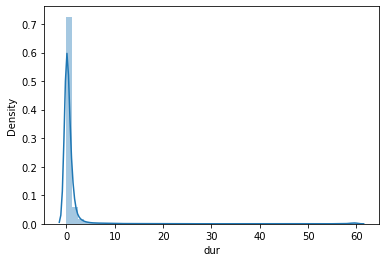

In [71]:
univariate(full_df['dur'])

In [72]:
print(np.percentile(full_df['dur'], [1, 50, 75, 85, 90, 95, 98, 99]))

[0.0000000e+00 4.2850000e-03 6.8577700e-01 1.0857574e+00 1.4704954e+00
 2.8114142e+00 1.1758444e+01 3.7853725e+01]


count   257673.000
mean        19.777
std        135.947
min          1.000
25%          2.000
50%          4.000
75%         12.000
max      10646.000
Name: spkts, dtype: float64


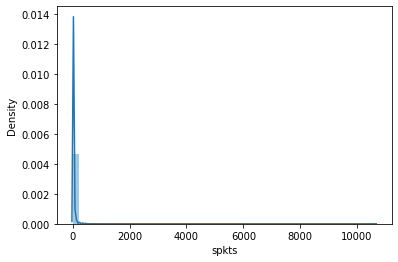

In [73]:
univariate(full_df['spkts'])

In [74]:
print(np.percentile(full_df['spkts'], [1, 50, 75, 85, 90, 95, 98, 99]))

[  1.   4.  12.  22.  42.  62. 122. 230.]


#### The data seems to be right skewed with extreme outliers on the higher side of the data.
#### Let us remove the higher side outliers by fixing the cutoff threshold as 90 percentile

In [75]:
perc_90 = np.percentile(full_df['dur'], 90)
perc_90

1.4704954000000017

In [76]:
full_df_wo_outliers = full_df.loc[full_df['dur'] < perc_90]
full_df_wo_outliers.shape

(231905, 43)

count   231905.000
mean         0.242
std          0.388
min          0.000
25%          0.000
50%          0.001
75%          0.434
max          1.470
Name: dur, dtype: float64


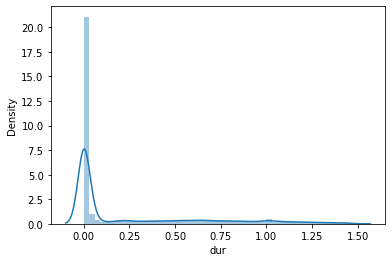

In [77]:
univariate(full_df_wo_outliers['dur'])

In [78]:
full_df_orig = full_df.copy()
full_df = full_df_wo_outliers 

# 3. Data Preparation For Modelling

## 3.1 Check class imbalance

In [79]:

full_df.label.value_counts()

1    146771
0     85134
Name: label, dtype: int64

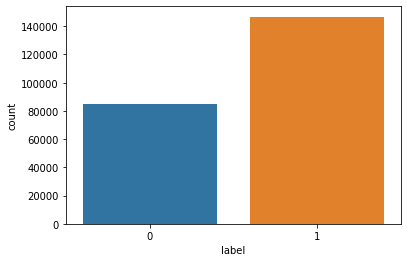

In [80]:
# Temporarily convert 'label' to category type, to aid visualization
full_df.label = full_df.label.astype('category')
univariate(full_df['label'], False)

#### We have a class imbalance in the dataset. The attack traffic is majority with 146771 records and normal traffic has only 85134 records. We have to address this class imbalance accordingly during modelling. 

In [82]:
# Let's check if any feature has only values as 0
num_vars, cat_vars = sep_num_cat(full_df)

zero_cols = [col for col in num_vars if full_df[col].sum()==0]
zero_cols

[]

In [83]:
cat_vars

['proto', 'service', 'state', 'label']

In [84]:
# convert label dtype back to int
full_df.label = full_df.label.astype('int')
full_df.label.dtype

dtype('int32')

In [85]:
full_df.shape

(231905, 43)

## 3.2 Transformation (One-hot encoding) of categorical variables

In [86]:
num_vars, cat_vars = sep_num_cat(full_df)
cat_vars

['proto', 'service', 'state']

In [87]:
proto_list = set(full_df.proto.values)
print(proto_list)
print(len(proto_list))

{'ospf', 'igmp', 'larp', 'ipip', 'isis', 'a/n', 'etherip', 'nsfnet-igp', 'pipe', 'crudp', 'st2', 'l2tp', 'br-sat-mon', 'pvp', 'nvp', 'iso-tp4', 'irtp', 'emcon', 'il', 'prm', 'visa', 'encap', 'idrp', 'tlsp', 'kryptolan', 'sps', 'micp', 'mfe-nsp', 'smp', 'ipnip', 'bbn-rcc', 'any', 'argus', 'cphb', 'vmtp', 'pri-enc', 'bna', 'cbt', 'skip', 'sat-expak', 'narp', 'tcf', 'egp', 'aris', 'qnx', 'chaos', 'ipcv', 'vrrp', 'trunk-1', 'ptp', 'sun-nd', 'swipe', 'fire', 'sat-mon', 'gmtp', 'aes-sp3-d', 'merit-inp', 'ggp', 'ib', 'ipv6-opts', 'udp', 'rsvp', 'idpr-cmtp', 'sm', 'ifmp', 'ippc', 'unas', 'cftp', 'crtp', 'compaq-peer', 'wb-mon', 'secure-vmtp', 'uti', 'xtp', 'idpr', 'hmp', 'pim', 'tp++', 'ipv6-no', 'xnet', 'ddx', 'ipv6-frag', 'iso-ip', 'pnni', 'sep', 'dcn', 'ipv6', 'igp', 'arp', 'trunk-2', 'sctp', 'sprite-rpc', 'ipx-n-ip', 'snp', 'vines', 'dgp', 'mhrp', 'pup', 'rtp', 'leaf-1', '3pc', 'mtp', 'mux', 'gre', 'ipcomp', 'ipv6-route', 'sdrp', 'tcp', 'leaf-2', 'i-nlsp', 'xns-idp', 'ip', 'scps', 'pgm', '

In [88]:
service_list = set(full_df.service.values)
print(service_list)
print(len(service_list))

{'pop3', 'unpopular', 'ftp', 'ftp-data', 'ssl', 'ssh', 'snmp', 'radius', 'http', 'dhcp', 'smtp', 'irc', 'dns'}
13


In [89]:
state_list = set(full_df.state.values)
print(state_list)
print(len(state_list))

{'req', 'con', 'eco', 'acc', 'rst', 'no', 'fin', 'clo', 'int', 'par', 'urn'}
11


#### There are three categorical variables - 'proto', 'service', 'state'. 
#### Let us apply one-hot encoding to these features to convert them to numerical values.

In [90]:
dummy1 = pd.get_dummies(full_df[['proto', 'service', 'state']])
dummy1

,proto_3pc,proto_a/n,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,...,state_clo,state_con,state_eco,state_fin,state_int,state_no,state_par,state_req,state_rst,state_urn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
257668,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
257670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
257671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [91]:
dummy1.columns

Index(['proto_3pc', 'proto_a/n', 'proto_aes-sp3-d', 'proto_any', 'proto_argus',
       'proto_aris', 'proto_arp', 'proto_ax.25', 'proto_bbn-rcc', 'proto_bna',
       ...
       'state_clo', 'state_con', 'state_eco', 'state_fin', 'state_int',
       'state_no', 'state_par', 'state_req', 'state_rst', 'state_urn'],
      dtype='object', length=156)

In [92]:
dummy2 = dummy1.drop(['proto_a/n', 'state_no', 'service_unpopular' ], 1)
dummy2

,proto_3pc,proto_aes-sp3-d,proto_any,proto_argus,proto_aris,proto_arp,proto_ax.25,proto_bbn-rcc,proto_bna,proto_br-sat-mon,...,state_acc,state_clo,state_con,state_eco,state_fin,state_int,state_par,state_req,state_rst,state_urn
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257667,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
257668,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
257670,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
257671,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [93]:
#dummy2.columns

In [94]:
full_df_new = pd.concat([full_df, dummy2], axis=1)
full_df_new.shape

(231905, 196)

In [95]:
full_df_new = full_df_new.drop(['proto', 'state', 'service'], 1)
full_df_new.shape

(231905, 193)

In [96]:
#full_df_new.info(verbose=1)
full_df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231905 entries, 0 to 257672
Columns: 193 entries, dur to state_urn
dtypes: float64(11), int32(1), int64(28), uint8(153)
memory usage: 115.5 MB


In [97]:
num_vars, cat_vars = sep_num_cat(full_df_new)
print(len(num_vars))
print(len(cat_vars))

193
0


## 3.3 Split original dataset in to Train-Test data 

In [98]:
y = full_df_new.pop('label')
X = full_df_new
X.shape

(231905, 192)

In [99]:
y.shape

(231905,)

In [100]:
from sklearn.model_selection import train_test_split

## Main set -> Train1, Test1
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=30000, random_state=42, stratify=y)

## 3.4 Standard Scaling of Features

In [101]:
from sklearn.preprocessing import StandardScaler
# Scale the training set
std_scaler = StandardScaler()

X_train1_std_scaled = std_scaler.fit_transform(X_train1)
X_train1_std_scaled

array([[-0.62210931, -0.43169889, -0.3222141 , ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       [-0.62209385, -0.43169889, -0.3222141 , ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       [ 1.46132753, -0.06667776, -0.13549   , ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       ...,
       [-0.50252632, -0.24918833, -0.07324863, ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       [-0.62209643, -0.43169889, -0.3222141 , ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       [-0.40745143,  2.21470435,  1.60726829, ..., -0.08674712,
        -0.01780678, -0.0022255 ]])

In [102]:
# Scale transform the testing set
X_test1_std_scaled = std_scaler.transform(X_test1)
X_test1_std_scaled

array([[-0.62209643, -0.43169889, -0.3222141 , ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       [-0.62209643, -0.43169889, -0.3222141 , ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       [-0.4084536 ,  0.48085395,  0.11347547, ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       ...,
       [-0.62210931, -0.43169889, -0.3222141 , ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       [-0.62210416, -0.43169889, -0.3222141 , ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       [-0.61935012, -0.43169889, -0.25997273, ..., -0.08674712,
        -0.01780678, -0.0022255 ]])

In [103]:
X_train1 = X_train1_std_scaled
X_test1 = X_test1_std_scaled

In [104]:
print(X_train1.shape, y_train1.shape, X_test1.shape, y_test1.shape)

(201905, 192) (201905,) (30000, 192) (30000,)


#### Split further for Autoencoder training and testing

In [105]:
## Train1 -> Train2, Test2  ( Train and test Auto-encoder using this )
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train1, y_train1, test_size=30000, random_state=42, stratify=y_train1)

In [106]:
print(X_train2.shape, y_train2.shape, X_test2.shape, y_test2.shape)

(171905, 192) (171905,) (30000, 192) (30000,)


In [107]:
### Check for similar distribution of classes in both train and test sets
print(y_train2.sum()/len(y_train2))

0.6328902591547657


In [108]:
print(y_test2.sum()/len(y_test2))

0.6329


# 4. Modelling

## 4.1 Auto Encoder

### We will train and use a Symmetric Stacked Auto Encoder (SAE) with tied weights and gaussian denoising technique.

In [114]:
import tensorflow as tf
from tensorflow import keras 

In [115]:
X_train2.shape

(171905, 192)

In [116]:
# When an autoencoder is symmetrical, a common technique is to tie the weights of 
# the decoder layers to that of the encoder layers. This limits the risk of overfitting,
# halves the number of weights in the model, speeding up training. This is done by transposing
# the weights of encoder for the decoder.

# Code to tie the weights of encoder and decoder

class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

### 4.1.1 Training AutoEncoder

The auto-encoder will have two hidden encoder layers to extract latent features from the input features
and two decoder layers ( one hidden and another output layer ) to reconstruct the input features back from the latent features provided by the encoder layers. 

#### 4.1.1.1 Hyper-Parameter Tuning of Auto Encoder

In [117]:
# Method to build a AE with the given parameters, for grid search hyper-parameter tuning.

# We use 
# layer_sizes - Number of neurons in first encoder layer and second encoder layer, respectively.
# Learn rate - Learning rate for Stochastic Gradient Descent Learning.
# gnoise - Gaussian noise fraction to be tried
# input shape - input shape of data

def tuneModel(layer_sizes, learn_rate, gnoise, input_shape = X_train2.shape[1]): 
    
    print(layer_sizes)
    print(learn_rate)
    print(gnoise)
    
    dense_1 = keras.layers.Dense(layer_sizes[0], activation="selu")
    dense_2 = keras.layers.Dense(layer_sizes[1], activation="selu")
    
    #print("here")
    
    tied_encoder = keras.models.Sequential([
      keras.layers.Flatten(input_shape=[X_train2.shape[1]]),
      keras.layers.GaussianNoise(gnoise),
      dense_1,
      dense_2
    ])

    tied_decoder = keras.models.Sequential([
      DenseTranspose(dense_2, activation="selu"),
      DenseTranspose(dense_1, activation="selu"),
    ])

    stacked_ae = keras.models.Sequential([tied_encoder, tied_decoder])
    stacked_ae.compile(loss = "mse", optimizer=keras.optimizers.SGD(lr=learn_rate))
    
    print(tied_encoder.summary())
    print()
    print(tied_decoder.summary())
    print()
    print(stacked_ae.summary())
    
    return stacked_ae

#### Use RandomizedSearchCV search for best hyperparameter combination 

Hidden layer sizes (First encoder layer size, Second encoder layer size)  = [(150,75), (120,60), (100,50)] <br>
learn_rate=[0.001, 0.002, 0.005], <br>
gnoise=[0.1, 0.2, 0.3] <br>

In [125]:
keras.backend.clear_session()
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

shapes = [(150,75), (120,60), (100,50)]


model = KerasRegressor(tuneModel, verbose=0)

param_grid = dict(
    layer_sizes=shapes,
    learn_rate=[0.001, 0.002, 0.005],
    gnoise=[0.1, 0.2, 0.3] 
    )

grid_layers = RandomizedSearchCV(model, param_grid, n_iter=15, cv=3, verbose=1, scoring='neg_mean_squared_error')

#### Early stop the training if there is no improvement in val_loss for 5 epochs.
early_stopping = keras.callbacks.EarlyStopping(monitor='loss', patience= 5, min_delta=0.0001, verbose=1)

grid_result_layers = grid_layers.fit(X_train2, X_train2, epochs=100, callbacks=[early_stopping], verbose=1)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
(120, 60)
0.001
0.2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 120)               23160     
_________________________________________________________________
dense_1 (Dense)              (None, 60)                7260      
Total params: 30,420
Trainable params: 30,420
Non-trainable params: 0
_________________________________________________________________
None

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_tra

3582/3582 [==============================] - 6s 2ms/step - loss: 0.3383
Epoch 43/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.3328
Epoch 44/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.3277
Epoch 45/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.3226
Epoch 46/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.3178
Epoch 47/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.3132
Epoch 48/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.3088
Epoch 49/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.3043
Epoch 50/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.3004
Epoch 51/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2960
Epoch 52/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2923
Epoch 53/100
3582/3582 [==============================] - 5s 2ms/step - loss: 

3582/3582 [==============================] - 6s 2ms/step - loss: 0.7566
Epoch 2/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.6173
Epoch 3/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.5435
Epoch 4/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.4730
Epoch 5/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.4022
Epoch 6/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.3455
Epoch 7/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.3079
Epoch 8/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2817
Epoch 9/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2722
Epoch 10/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2474
Epoch 11/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2367
Epoch 12/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2292
E

3582/3582 [==============================] - 6s 2ms/step - loss: 0.7642
Epoch 2/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.6207
Epoch 3/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.5420
Epoch 4/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.4673
Epoch 5/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.3964
Epoch 6/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.3407
Epoch 7/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.3023
Epoch 8/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2843
Epoch 9/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2702
Epoch 10/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2562
Epoch 11/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2434
Epoch 12/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2340
E

Epoch 41/100
3582/3582 [==============================] - 5s 2ms/step - loss: 0.2743
Epoch 42/100
3582/3582 [==============================] - 5s 2ms/step - loss: 0.2711
Epoch 43/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2679
Epoch 44/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2647
Epoch 45/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2616
Epoch 46/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2592
Epoch 47/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2563
Epoch 48/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2537A: 0s - loss:
Epoch 49/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2514
Epoch 50/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2491
Epoch 51/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.2468
Epoch 52/100
3582/3582 [============================

3582/3582 [==============================] - 5s 2ms/step - loss: 0.9341
Epoch 2/100
3582/3582 [==============================] - 5s 1ms/step - loss: 0.7803
Epoch 3/100
3582/3582 [==============================] - 5s 2ms/step - loss: 0.7335
Epoch 4/100
3582/3582 [==============================] - 5s 1ms/step - loss: 0.7016
Epoch 5/100
3582/3582 [==============================] - 5s 1ms/step - loss: 0.6768
Epoch 6/100
3582/3582 [==============================] - 5s 1ms/step - loss: 0.6560
Epoch 7/100
3582/3582 [==============================] - 5s 1ms/step - loss: 0.6377
Epoch 8/100
3582/3582 [==============================] - 5s 2ms/step - loss: 0.6208
Epoch 9/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.6049
Epoch 10/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.5895
Epoch 11/100
3582/3582 [==============================] - 5s 2ms/step - loss: 0.5744
Epoch 12/100
3582/3582 [==============================] - 6s 2ms/step - loss: 0.5596
E

3582/3582 [==============================] - 3s 946us/step - loss: 0.2431
Epoch 68/100
3582/3582 [==============================] - 3s 929us/step - loss: 0.2415
Epoch 69/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.2400
Epoch 70/100
3582/3582 [==============================] - 3s 937us/step - loss: 0.2385
Epoch 71/100
3582/3582 [==============================] - 3s 956us/step - loss: 0.2372
Epoch 72/100
3582/3582 [==============================] - 3s 920us/step - loss: 0.2358
Epoch 73/100
3582/3582 [==============================] - 3s 929us/step - loss: 0.2345
Epoch 74/100
3582/3582 [==============================] - 3s 931us/step - loss: 0.2332
Epoch 75/100
3582/3582 [==============================] - 3s 927us/step - loss: 0.2321
Epoch 76/100
3582/3582 [==============================] - 3s 962us/step - loss: 0.2308
Epoch 77/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.2296
Epoch 78/100
3582/3582 [==============================] - 3s

3582/3582 [==============================] - 3s 851us/step - loss: 0.7184
Epoch 6/100
3582/3582 [==============================] - 3s 852us/step - loss: 0.6990
Epoch 7/100
3582/3582 [==============================] - 3s 924us/step - loss: 0.6817
Epoch 8/100
3582/3582 [==============================] - 3s 890us/step - loss: 0.6660
Epoch 9/100
3582/3582 [==============================] - 3s 860us/step - loss: 0.6515
Epoch 10/100
3582/3582 [==============================] - 3s 850us/step - loss: 0.6378
Epoch 11/100
3582/3582 [==============================] - 3s 851us/step - loss: 0.6247
Epoch 12/100
3582/3582 [==============================] - 3s 879us/step - loss: 0.6119
Epoch 13/100
3582/3582 [==============================] - 3s 853us/step - loss: 0.5992
Epoch 14/100
3582/3582 [==============================] - 3s 854us/step - loss: 0.5866
Epoch 15/100
3582/3582 [==============================] - 3s 852us/step - loss: 0.5740
Epoch 16/100
3582/3582 [==============================] - 3s

Epoch 70/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1861
Epoch 71/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1844
Epoch 72/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1829
Epoch 73/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1813
Epoch 74/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1798
Epoch 75/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1784
Epoch 76/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1771
Epoch 77/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1758
Epoch 78/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1745
Epoch 79/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1733
Epoch 80/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1721
Epoch 81/100
3582/3582 [==============================] - 4s 1ms/

3582/3582 [==============================] - 4s 1ms/step - loss: 0.3363
Epoch 42/100
3582/3582 [==============================] - 4s 995us/step - loss: 0.3301
Epoch 43/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.3240
Epoch 44/100
3582/3582 [==============================] - 4s 990us/step - loss: 0.3179
Epoch 45/100
3582/3582 [==============================] - 4s 993us/step - loss: 0.3120
Epoch 46/100
3582/3582 [==============================] - 4s 993us/step - loss: 0.3060
Epoch 47/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.3002
Epoch 48/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.2943
Epoch 49/100
3582/3582 [==============================] - 4s 997us/step - loss: 0.2881
Epoch 50/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.2818
Epoch 51/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.2757
Epoch 52/100
3582/3582 [==============================] - 4s 1ms/ste

3582/3582 [==============================] - 4s 1ms/step - loss: 0.8033
Epoch 2/100
3582/3582 [==============================] - 4s 997us/step - loss: 0.6606
Epoch 3/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.6008
Epoch 4/100
3582/3582 [==============================] - 4s 982us/step - loss: 0.5521
Epoch 5/100
3582/3582 [==============================] - 4s 985us/step - loss: 0.5062
Epoch 6/100
3582/3582 [==============================] - 3s 943us/step - loss: 0.4593
Epoch 7/100
3582/3582 [==============================] - 3s 962us/step - loss: 0.4168
Epoch 8/100
3582/3582 [==============================] - 3s 943us/step - loss: 0.3767
Epoch 9/100
3582/3582 [==============================] - 3s 940us/step - loss: 0.3524
Epoch 10/100
3582/3582 [==============================] - 3s 932us/step - loss: 0.3331
Epoch 11/100
3582/3582 [==============================] - 3s 932us/step - loss: 0.3186
Epoch 12/100
3582/3582 [==============================] - 3s 958us/s

3582/3582 [==============================] - 3s 947us/step - loss: 0.1545
Epoch 58/100
3582/3582 [==============================] - 3s 938us/step - loss: 0.1494
Epoch 59/100
3582/3582 [==============================] - 3s 932us/step - loss: 0.1559
Epoch 00059: early stopping
(150, 75)
0.005
0.3
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 192)               0         
_________________________________________________________________
gaussian_noise_18 (GaussianN (None, 192)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 150)               28950     
_________________________________________________________________
dense_37 (Dense)             (None, 75)                11325     
Total params: 40,275
Trainable params: 40,275
Non-trainable params: 0
_________________

3582/3582 [==============================] - 4s 1ms/step - loss: 0.8023
Epoch 2/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.6371
Epoch 3/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.5755
Epoch 4/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.5272
Epoch 5/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.4836
Epoch 6/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.4424
Epoch 7/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.4037
Epoch 8/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.3737
Epoch 9/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.3434
Epoch 10/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.3250
Epoch 11/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.3048
Epoch 12/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.2773
E

3582/3582 [==============================] - 4s 1ms/step - loss: 0.1960
Epoch 51/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1942
Epoch 52/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1925
Epoch 53/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1909
Epoch 54/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1892
Epoch 55/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1877
Epoch 56/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1862
Epoch 57/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1848
Epoch 58/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1834
Epoch 59/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1820
Epoch 60/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1808
Epoch 61/100
3582/3582 [==============================] - 4s 1ms/step - loss: 

3582/3582 [==============================] - 4s 1ms/step - loss: 0.8947
Epoch 2/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.7238
Epoch 3/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.6682
Epoch 4/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.6317
Epoch 5/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.6022
Epoch 6/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.5763
Epoch 7/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.5526
Epoch 8/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.5304
Epoch 9/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.5091
Epoch 10/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.4885
Epoch 11/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.4687
Epoch 12/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.4489
E

3582/3582 [==============================] - 3s 937us/step - loss: 0.8494
Epoch 2/100
3582/3582 [==============================] - 3s 973us/step - loss: 0.7002
Epoch 3/100
3582/3582 [==============================] - 3s 938us/step - loss: 0.6463
Epoch 4/100
3582/3582 [==============================] - 3s 939us/step - loss: 0.6079
Epoch 5/100
3582/3582 [==============================] - 3s 935us/step - loss: 0.5749
Epoch 6/100
3582/3582 [==============================] - 3s 953us/step - loss: 0.5442
Epoch 7/100
3582/3582 [==============================] - 3s 936us/step - loss: 0.5119
Epoch 8/100
3582/3582 [==============================] - 3s 925us/step - loss: 0.4808
Epoch 9/100
3582/3582 [==============================] - 3s 930us/step - loss: 0.4481
Epoch 10/100
3582/3582 [==============================] - 3s 934us/step - loss: 0.4198
Epoch 11/100
3582/3582 [==============================] - 3s 953us/step - loss: 0.3942
Epoch 12/100
3582/3582 [==============================] - 3s 930

3582/3582 [==============================] - 3s 963us/step - loss: 0.2116
Epoch 51/100
3582/3582 [==============================] - 3s 945us/step - loss: 0.2089
Epoch 52/100
3582/3582 [==============================] - 3s 941us/step - loss: 0.2070
Epoch 53/100
3582/3582 [==============================] - 3s 949us/step - loss: 0.2054
Epoch 54/100
3582/3582 [==============================] - 3s 947us/step - loss: 0.2035
Epoch 55/100
3582/3582 [==============================] - 3s 966us/step - loss: 0.2020
Epoch 56/100
3582/3582 [==============================] - 3s 941us/step - loss: 0.2004
Epoch 57/100
3582/3582 [==============================] - 3s 937us/step - loss: 0.1988
Epoch 58/100
3582/3582 [==============================] - 3s 940us/step - loss: 0.1976
Epoch 59/100
3582/3582 [==============================] - 3s 934us/step - loss: 0.1963
Epoch 60/100
3582/3582 [==============================] - 3s 968us/step - loss: 0.1949
Epoch 61/100
3582/3582 [==============================] 

3582/3582 [==============================] - 3s 946us/step - loss: 0.8938
Epoch 2/100
3582/3582 [==============================] - 3s 954us/step - loss: 0.7429
Epoch 3/100
3582/3582 [==============================] - 3s 956us/step - loss: 0.6921
Epoch 4/100
3582/3582 [==============================] - 4s 977us/step - loss: 0.6568
Epoch 5/100
3582/3582 [==============================] - 3s 958us/step - loss: 0.6285
Epoch 6/100
3582/3582 [==============================] - 3s 946us/step - loss: 0.6039
Epoch 7/100
3582/3582 [==============================] - 3s 947us/step - loss: 0.5813
Epoch 8/100
3582/3582 [==============================] - 3s 942us/step - loss: 0.5599
Epoch 9/100
3582/3582 [==============================] - 3s 968us/step - loss: 0.5393
Epoch 10/100
3582/3582 [==============================] - 3s 949us/step - loss: 0.5196
Epoch 11/100
3582/3582 [==============================] - 3s 948us/step - loss: 0.5000
Epoch 12/100
3582/3582 [==============================] - 3s 944

3582/3582 [==============================] - 4s 1ms/step - loss: 0.1358
Epoch 67/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1350
Epoch 68/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1343
Epoch 69/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1338
Epoch 70/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1330
Epoch 71/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1326
Epoch 72/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1319
Epoch 73/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1314
Epoch 74/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1312
Epoch 75/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1303
Epoch 76/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.1298
Epoch 77/100
3582/3582 [==============================] - 4s 1ms/step - loss: 

3582/3582 [==============================] - 4s 1ms/step - loss: 0.3965
Epoch 9/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.3636
Epoch 10/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.3349
Epoch 11/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.3107
Epoch 12/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.2906
Epoch 13/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.2742
Epoch 14/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.2609
Epoch 15/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.2499
Epoch 16/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.2405
Epoch 17/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.2326
Epoch 18/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0.2254
Epoch 19/100
3582/3582 [==============================] - 4s 1ms/step - loss: 0

3582/3582 [==============================] - 3s 897us/step - loss: 0.9573
Epoch 2/100
3582/3582 [==============================] - 3s 904us/step - loss: 0.8038
Epoch 3/100
3582/3582 [==============================] - 3s 901us/step - loss: 0.7573
Epoch 4/100
3582/3582 [==============================] - 3s 938us/step - loss: 0.7275
Epoch 5/100
3582/3582 [==============================] - 3s 907us/step - loss: 0.7055
Epoch 6/100
3582/3582 [==============================] - 3s 900us/step - loss: 0.6875
Epoch 7/100
3582/3582 [==============================] - 3s 897us/step - loss: 0.6723
Epoch 8/100
3582/3582 [==============================] - 3s 897us/step - loss: 0.6585
Epoch 9/100
3582/3582 [==============================] - 3s 941us/step - loss: 0.6461
Epoch 10/100
3582/3582 [==============================] - 3s 900us/step - loss: 0.6348
Epoch 11/100
3582/3582 [==============================] - 3s 906us/step - loss: 0.6240
Epoch 12/100
3582/3582 [==============================] - 3s 899

3582/3582 [==============================] - 3s 894us/step - loss: 0.2079
Epoch 65/100
3582/3582 [==============================] - 3s 900us/step - loss: 0.2055
Epoch 66/100
3582/3582 [==============================] - 3s 927us/step - loss: 0.2037
Epoch 67/100
3582/3582 [==============================] - 3s 909us/step - loss: 0.2019
Epoch 68/100
3582/3582 [==============================] - 3s 896us/step - loss: 0.2001
Epoch 69/100
3582/3582 [==============================] - 3s 897us/step - loss: 0.1987
Epoch 70/100
3582/3582 [==============================] - 3s 898us/step - loss: 0.1972
Epoch 71/100
3582/3582 [==============================] - 3s 927us/step - loss: 0.1957
Epoch 72/100
3582/3582 [==============================] - 3s 906us/step - loss: 0.1950
Epoch 73/100
3582/3582 [==============================] - 3s 896us/step - loss: 0.1929
Epoch 74/100
3582/3582 [==============================] - 3s 894us/step - loss: 0.1918
Epoch 75/100
3582/3582 [==============================] 

3582/3582 [==============================] - 3s 892us/step - loss: 0.8413
Epoch 3/100
3582/3582 [==============================] - 3s 890us/step - loss: 0.7926
Epoch 4/100
3582/3582 [==============================] - 3s 935us/step - loss: 0.7651
Epoch 5/100
3582/3582 [==============================] - 3s 890us/step - loss: 0.7440
Epoch 6/100
3582/3582 [==============================] - 3s 891us/step - loss: 0.7267
Epoch 7/100
3582/3582 [==============================] - 3s 892us/step - loss: 0.7118
Epoch 8/100
3582/3582 [==============================] - 3s 892us/step - loss: 0.6988
Epoch 9/100
3582/3582 [==============================] - 3s 933us/step - loss: 0.6872
Epoch 10/100
3582/3582 [==============================] - 3s 891us/step - loss: 0.6766
Epoch 11/100
3582/3582 [==============================] - 3s 890us/step - loss: 0.6667
Epoch 12/100
3582/3582 [==============================] - 3s 891us/step - loss: 0.6574
Epoch 13/100
3582/3582 [==============================] - 3s 89

3582/3582 [==============================] - 3s 896us/step - loss: 0.3098
Epoch 66/100
3582/3582 [==============================] - 3s 898us/step - loss: 0.3081
Epoch 67/100
3582/3582 [==============================] - 3s 928us/step - loss: 0.3044
Epoch 68/100
3582/3582 [==============================] - 3s 897us/step - loss: 0.3016
Epoch 69/100
3582/3582 [==============================] - 3s 897us/step - loss: 0.2990
Epoch 70/100
3582/3582 [==============================] - 3s 897us/step - loss: 0.2968
Epoch 71/100
3582/3582 [==============================] - 3s 897us/step - loss: 0.2941
Epoch 72/100
3582/3582 [==============================] - 3s 925us/step - loss: 0.2920
Epoch 73/100
3582/3582 [==============================] - 3s 897us/step - loss: 0.2898
Epoch 74/100
3582/3582 [==============================] - 3s 899us/step - loss: 0.2876
Epoch 75/100
3582/3582 [==============================] - 3s 903us/step - loss: 0.2854
Epoch 76/100
3582/3582 [==============================] 

3582/3582 [==============================] - 3s 890us/step - loss: 0.6089
Epoch 4/100
3582/3582 [==============================] - 3s 888us/step - loss: 0.5535
Epoch 5/100
3582/3582 [==============================] - 3s 892us/step - loss: 0.4954
Epoch 6/100
3582/3582 [==============================] - 3s 926us/step - loss: 0.4353
Epoch 7/100
3582/3582 [==============================] - 3s 888us/step - loss: 0.3806
Epoch 8/100
3582/3582 [==============================] - 3s 928us/step - loss: 0.3424
Epoch 9/100
3582/3582 [==============================] - 3s 892us/step - loss: 0.3132
Epoch 10/100
3582/3582 [==============================] - 3s 897us/step - loss: 0.2958
Epoch 11/100
3582/3582 [==============================] - 3s 912us/step - loss: 0.2927
Epoch 12/100
3582/3582 [==============================] - 3s 896us/step - loss: 0.2780
Epoch 13/100
3582/3582 [==============================] - 3s 890us/step - loss: 0.2661
Epoch 14/100
3582/3582 [==============================] - 3s 8

3582/3582 [==============================] - 3s 952us/step - loss: 0.7966
Epoch 2/100
3582/3582 [==============================] - 3s 907us/step - loss: 0.6715
Epoch 3/100
3582/3582 [==============================] - 3s 899us/step - loss: 0.6085
Epoch 4/100
3582/3582 [==============================] - 3s 899us/step - loss: 0.5520
Epoch 5/100
3582/3582 [==============================] - 3s 900us/step - loss: 0.4944
Epoch 6/100
3582/3582 [==============================] - 3s 938us/step - loss: 0.4357
Epoch 7/100
3582/3582 [==============================] - 3s 899us/step - loss: 0.3795
Epoch 8/100
3582/3582 [==============================] - 3s 903us/step - loss: 0.3367
Epoch 9/100
3582/3582 [==============================] - 3s 894us/step - loss: 0.3075
Epoch 10/100
3582/3582 [==============================] - 3s 895us/step - loss: 0.2908
Epoch 11/100
3582/3582 [==============================] - 3s 939us/step - loss: 0.2885
Epoch 12/100
3582/3582 [==============================] - 3s 906

3582/3582 [==============================] - 4s 992us/step - loss: 0.9424
Epoch 2/100
3582/3582 [==============================] - 3s 972us/step - loss: 0.7900
Epoch 3/100
3582/3582 [==============================] - 3s 964us/step - loss: 0.7397
Epoch 4/100
3582/3582 [==============================] - 3s 965us/step - loss: 0.7084 0
Epoch 5/100
3582/3582 [==============================] - 3s 975us/step - loss: 0.6839
Epoch 6/100
3582/3582 [==============================] - 3s 969us/step - loss: 0.6628
Epoch 7/100
3582/3582 [==============================] - 3s 961us/step - loss: 0.6436
Epoch 8/100
3582/3582 [==============================] - 3s 962us/step - loss: 0.6258
Epoch 9/100
3582/3582 [==============================] - 3s 960us/step - loss: 0.6089
Epoch 10/100
3582/3582 [==============================] - 4s 983us/step - loss: 0.5926
Epoch 11/100
3582/3582 [==============================] - 3s 972us/step - loss: 0.5768
Epoch 12/100
3582/3582 [==============================] - 3s 9

3582/3582 [==============================] - 3s 973us/step - loss: 0.2073
Epoch 65/100
3582/3582 [==============================] - 3s 972us/step - loss: 0.2061
Epoch 66/100
3582/3582 [==============================] - 3s 971us/step - loss: 0.2049
Epoch 67/100
3582/3582 [==============================] - 4s 991us/step - loss: 0.2038
Epoch 68/100
3582/3582 [==============================] - 3s 971us/step - loss: 0.2025
Epoch 69/100
3582/3582 [==============================] - 3s 970us/step - loss: 0.2015
Epoch 70/100
3582/3582 [==============================] - 3s 969us/step - loss: 0.2005
Epoch 71/100
3582/3582 [==============================] - 4s 994us/step - loss: 0.1994
Epoch 72/100
3582/3582 [==============================] - 3s 976us/step - loss: 0.1983
Epoch 73/100
3582/3582 [==============================] - 3s 969us/step - loss: 0.1973
Epoch 74/100
3582/3582 [==============================] - 3s 972us/step - loss: 0.1963
Epoch 75/100
3582/3582 [==============================] 

In [126]:
print("\nBest hyperparameters: ", grid_result_layers.best_params_)     
print("\nBest Score : %0.5f" % grid_result_layers.best_score_)
# scores of GridSearch CV
scores = pd.DataFrame(grid_result_layers.cv_results_)
scores


Best hyperparameters:  {'learn_rate': 0.002, 'layer_sizes': (150, 75), 'gnoise': 0.1}

Best Score : -0.11774


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learn_rate,param_layer_sizes,param_gnoise,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,564.351,4.934,1.371,0.078,0.001,"(120, 60)",0.200,"{'learn_rate': 0.001, 'layer_sizes': (120, 60)...",-0.179,-0.159,-0.197,-0.178,0.016,12
1,186.807,5.202,1.389,0.102,0.005,"(120, 60)",0.100,"{'learn_rate': 0.005, 'layer_sizes': (120, 60)...",-0.152,-0.142,-0.175,-0.156,0.014,7
2,545.844,7.577,1.255,0.086,0.002,"(100, 50)",0.200,"{'learn_rate': 0.002, 'layer_sizes': (100, 50)...",-0.170,-0.152,-0.188,-0.170,0.015,10
3,10744.292,14744.419,0.642,0.002,0.001,"(100, 50)",0.100,"{'learn_rate': 0.001, 'layer_sizes': (100, 50)...",-0.197,-0.180,-0.218,-0.198,0.015,14
4,379.732,10.288,0.812,0.087,0.001,"(150, 75)",0.300,"{'learn_rate': 0.001, 'layer_sizes': (150, 75)...",-0.150,-0.132,-0.168,-0.150,0.015,5
5,158.976,30.562,0.679,0.023,0.005,"(120, 60)",0.200,"{'learn_rate': 0.005, 'layer_sizes': (120, 60)...",-0.166,-0.137,-0.158,-0.154,0.012,6
6,179.483,18.054,0.721,0.012,0.005,"(150, 75)",0.300,"{'learn_rate': 0.005, 'layer_sizes': (150, 75)...",-0.114,-0.109,-0.138,-0.120,0.013,2
7,377.341,3.728,0.786,0.103,0.001,"(150, 75)",0.100,"{'learn_rate': 0.001, 'layer_sizes': (150, 75)...",-0.140,-0.124,-0.161,-0.142,0.015,3
8,149.835,17.131,0.674,0.010,0.005,"(120, 60)",0.300,"{'learn_rate': 0.005, 'layer_sizes': (120, 60)...",-0.143,-0.177,-0.158,-0.159,0.014,8
9,341.719,1.642,0.664,0.007,0.002,"(120, 60)",0.200,"{'learn_rate': 0.002, 'layer_sizes': (120, 60)...",-0.147,-0.128,-0.166,-0.147,0.015,4


#### 4.1.1.2 Fit AutoEncoder

#### Train Autoencoder with the hyper-parameters found by random search cv
Best hyperparameters:  {'learn_rate': 0.002, 'layer_sizes': (150, 75), 'gnoise': 0.1}

In [119]:
keras.backend.clear_session()
tf.random.set_seed(42)
#tf.random.set_random_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(150, activation="selu")
dense_2 = keras.layers.Dense(75, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[X_train2.shape[1]]),
    keras.layers.GaussianNoise(0.1),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="selu"),
])

stacked_ae = keras.models.Sequential([tied_encoder, tied_decoder])

stacked_ae.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.002))


print(tied_encoder.summary())
print()
print(tied_decoder.summary())
print()
print(stacked_ae.summary())

#### Early stop the training if there is no improvement in val_loss for 5 epochs.
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, min_delta=0.0001, verbose=1)

history = stacked_ae.fit(X_train2, X_train2, epochs=200, batch_size=32,
                        validation_data=(X_test2, X_test2), callbacks=[early_stopping])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 150)               28950     
_________________________________________________________________
dense_1 (Dense)              (None, 75)                11325     
Total params: 40,275
Trainable params: 40,275
Non-trainable params: 0
_________________________________________________________________
None

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_transpose (DenseTransp (None, 150)               11475     
________________________

5373/5373 [==============================] - 6s 1ms/step - loss: 0.0954 - val_loss: 0.1171
Epoch 138/200
5373/5373 [==============================] - 6s 1ms/step - loss: 0.0952 - val_loss: 0.1189
Epoch 139/200
5373/5373 [==============================] - 6s 1ms/step - loss: 0.0952 - val_loss: 0.1168
Epoch 140/200
5373/5373 [==============================] - 6s 1ms/step - loss: 0.0949 - val_loss: 0.1167
Epoch 141/200
5373/5373 [==============================] - 6s 1ms/step - loss: 0.0948 - val_loss: 0.1166
Epoch 142/200
5373/5373 [==============================] - 6s 1ms/step - loss: 0.0946 - val_loss: 0.1167
Epoch 143/200
5373/5373 [==============================] - 6s 1ms/step - loss: 0.0943 - val_loss: 0.1163
Epoch 144/200
5373/5373 [==============================] - 6s 1ms/step - loss: 0.0943 - val_loss: 0.1161
Epoch 145/200
5373/5373 [==============================] - 6s 1ms/step - loss: 0.0940 - val_loss: 0.1160
Epoch 146/200
5373/5373 [==============================] - 6s 1ms/ste

In [120]:
stacked_encoder = tied_encoder
stacked_decoder = tied_decoder

In [121]:
stacked_encoder.save('enc', overwrite=True)
stacked_decoder.save('dec', overwrite=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: enc\assets
INFO:tensorflow:Assets written to: dec\assets


In [122]:
#stacked_encoder1 = keras.models.load_model("enc")
#stacked_decoder1 = keras.models.load_model("dec")

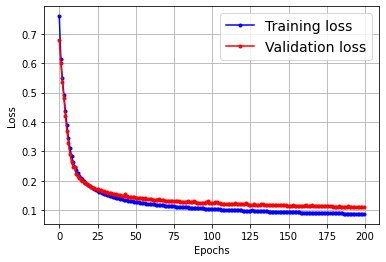

In [125]:
## Check the learning curves of how training loss and validation loss decrease over epochs

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### 4.1.2 Verify AutoEncoder

#### Using a couple of test samples, check the similarity of re-constructed output of the AE with the input values 

In [209]:
# Encode the X_test2 set with the encoder
encodings_to_verify = stacked_encoder.predict(X_test2)

In [210]:
# Get the decodings back from the encoded values, using the decoder
decodings_to_verify = stacked_decoder.predict(encodings_to_verify)

In [211]:
# Test a couple of test data. We can see that the trained AE is able to reconstruct fairly closely to the input values
print(X_test2[1,:10])
print()
print(decodings_to_verify[1, :10])

[-0.62209385 -0.43169889 -0.3222141  -0.24044296 -0.14269296  0.05895298
  0.69542507 -0.6894596  -0.14260903 -0.28276637]

[-0.6238017  -0.4711501  -0.3342756  -0.35745323 -0.14541715  0.14540125
  0.717012   -0.69536704 -0.14558409 -0.33749497]


In [212]:
print(X_test2[10,:10])
print()
print(decodings_to_verify[10, :10])

[-0.62209385 -0.43169889 -0.3222141  -0.24044296 -0.14269296  0.05895298
  0.69542507 -0.6894596  -0.14260903 -0.28276637]

[-0.63418186 -0.47718406 -0.33795103 -0.3394334  -0.150814    0.16881683
  0.7257984  -0.7057223  -0.10996556 -0.33454993]


### 4.1.3 Extract Features Using AutoEncoder

#### Now use the encoder part of the trained AE to encode the whole Train1 training set. Essentially this is extracting a low dimensional feature set.
This encoded training set will be further split to train and test the stacking base models and blender.

In [134]:
X_train1_AE_encodings = stacked_encoder.predict(X_train1)

In [135]:
X_train1_AE_encodings

array([[ 0.31696823,  0.4419001 , -1.3463588 , ...,  0.5295728 ,
         0.12739538,  0.26825556],
       [ 1.4799452 ,  9.201553  ,  6.889114  , ..., -1.1198701 ,
         5.769218  , -0.76616955],
       [-1.2488676 , -1.1347367 ,  0.55561393, ...,  0.3561751 ,
         0.45408875, -1.1120504 ],
       ...,
       [-1.1976529 ,  0.34516874,  0.0351708 , ...,  1.3581378 ,
        -0.5586594 , -1.4228177 ],
       [ 0.52861065,  1.1894176 , -1.4268789 , ..., -0.7166113 ,
         0.4134095 ,  0.38037267],
       [-1.2110305 , -1.4591731 ,  1.0920972 , ...,  1.0821443 ,
         0.45863953,  0.16046421]], dtype=float32)

In [136]:
X_train1_AE_encodings.shape

(201905, 75)

In [138]:
import joblib
joblib.dump(X_train1_AE_encodings, 'X_train1_AE_encodings.pkl')

['X_train1_AE_encodings.pkl']

In [139]:
joblib.dump(y_train1, 'y_train1.pkl')

['y_train1.pkl']

In [140]:
#import joblib
#X_train1_AE_encodings = joblib.load('X_train1_AE_encodings.pkl')
#y_train1 = joblib.load('y_train1.pkl')

#### Split the encoded data set further for training and testing the stacking classifier model to be built

In [141]:
# X_test3, y_test3 will be set aside for testing the stacking blender.
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_train1_AE_encodings, y_train1, test_size=30000, random_state=42, 
                                                        stratify=y_train1)

# X_train4, y_train4, X_test4, y_test4 will be used to train and test individual base models
# After training the base models, their predictions on X_test4, along with y_test4 will be 
# used to train the stacking blender, as this set was not learnt by base models.

X_train4, X_test4, y_train4, y_test4 = train_test_split(X_train3, y_train3, test_size=50000, random_state=42, stratify=y_train3)

In [142]:
X_train3.shape, y_train3.shape, X_test3.shape,  y_test3.shape

((171905, 75), (171905,), (30000, 75), (30000,))

In [143]:
X_train4.shape, y_train4.shape, X_test4.shape, y_test4.shape

((121905, 75), (121905,), (50000, 75), (50000,))

## 4.2 Stacking Classifier Model

We will train a stacking classifier which will classify normal vs attack traffic, using the feature encodings extracted by the autoencoder we trained.
The stacking classifier contains three base models.
1. SVM <br>
2. RF <br>
3. XGBoost <br>
and <br>
a final blender model which will be a Logistic Regression model. <br><br>
The idea of the stacking is all the three base models will separately classify (predict) the input data as normal(Label 0) vs Attack(Label 1). Then the predictions of the three base models will be used as features by the blender model to give out it's final verdict. So the input for the blender will be a set of three values (3-D feature set), for example [1, 0, 1] and it will give out the verdict as normal (0) or attack (1). 


### 4.2.1 Base Models 

#### 4.2.1.1 Base Model-1 ( Support Vector Machine Classifier )

##### Build a simple SVM model first

In [144]:
from sklearn.svm import SVC

In [145]:
## Train a simple SVM model. Use class_weight='balanced' as the dataset has some class imbalance. 
### Use probability=True as SVM by default does not calculate class probabilities.

svm_model = SVC(kernel='rbf', probability=True, class_weight='balanced')

svm_model.fit(X_train4, y_train4)

SVC(class_weight='balanced', probability=True)

In [146]:
# Get the predictions along with probabilities on the train set
y_train4_pred_svm, y_train4_pred_prob_svm  = predict_and_proba(svm_model, X_train4)

In [147]:
# Confusion matrix and other evaluation metric results on Train Data
print_binary_classification_summary(y_train4, y_train4_pred_svm)



Confusion Matrix :

 [[40390  4363]
 [ 7743 69409]]

TN : 40390

FP : 4363

FN : 7743

TP : 69409

ACCURACY :  0.9006931627086666

SENSITIVITY :  0.8996396723351306

PRECISION :  0.9408583202298976

FALSE POSITIVITY RATE :  0.09749067101646818

SPECIFICITY :  0.9025093289835319


 Classification Report :

               precision    recall  f1-score   support

           0       0.84      0.90      0.87     44753
           1       0.94      0.90      0.92     77152

    accuracy                           0.90    121905
   macro avg       0.89      0.90      0.89    121905
weighted avg       0.90      0.90      0.90    121905



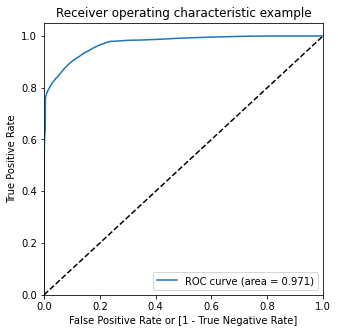


AUC SCORE = 0.971


0.9709228153808671

In [148]:
# Analyse the ROC curve
draw_roc(y_train4, y_train4_pred_prob_svm[:,1])

##### We got a good AUC score, accuracy, sensitivity and precision with train data

In [157]:
# Get the predictions along with probabilities on the test set
y_test4_pred_svm, y_test4_pred_prob_svm  = predict_and_proba(svm_model, X_test4)

In [158]:
# # Confusion matrix and other evaluation metric results on Test Data
print_binary_classification_summary(y_test4, y_test4_pred_svm)



Confusion Matrix :

 [[16520  1835]
 [ 3207 28438]]

TN : 16520

FP : 1835

FN : 3207

TP : 28438

ACCURACY :  0.89916

SENSITIVITY :  0.8986569758255648

PRECISION :  0.939384930466092

FALSE POSITIVITY RATE :  0.09997275946608554

SPECIFICITY :  0.9000272405339145


 Classification Report :

               precision    recall  f1-score   support

           0       0.84      0.90      0.87     18355
           1       0.94      0.90      0.92     31645

    accuracy                           0.90     50000
   macro avg       0.89      0.90      0.89     50000
weighted avg       0.90      0.90      0.90     50000



#### We got a good AUC score, accuracy, sensitivity and precision with test data also. 
So SVM seems to be a good candidate to be used as a base model.

#### Let's tune hyper-parameters of SVM model.

##### First, search for best hyper-parameters using RandomizedSearchCV
We try to tune the following hyper-parameters of SVM algorithm.
Gamma
C
We use AUC as the scoring measure to evaluate the best model.

In [161]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

hyper_params = [{'gamma': [1e-2, 1e-3, 1e-4, 'scale', 'auto'],
                 'C': [1, 10, 100, 1000]}]

svm_model2 = SVC(kernel='rbf', class_weight='balanced', probability=True)

# Use Multi scorer
scoring_measures = {'Precision': 'precision', 'Recall': 'recall', 'AUC' : 'roc_auc'}
refit = 'AUC'

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)

random_search_svm =  RandomizedSearchCV(estimator=svm_model2, param_distributions=hyper_params, scoring=scoring_measures, 
                                       cv=folds, refit=refit, n_jobs=-1, verbose=1, n_iter=10, random_state=100)

random_results_svm = random_search_svm.fit(X_train4, y_train4)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [162]:
# Print the best score found by Random Search and the best hyper-param combination
svm_rdm_best_score = grid_result_summary(random_results_svm, scoring_measures, refit)

mean_test_AUC

Best hyperparameters:  {'gamma': 'scale', 'C': 1000}

Best Score : 0.98290
   mean_test_Precision  mean_test_Recall  mean_test_AUC
3                0.972             0.896          0.983


##### Now, use GridSearchCV to further fine tune and search for best hyper-parameters based on the randomly chosen best parameter values by RandomizedSearchCV

In [163]:
hyper_params = [{'gamma': ['scale', 'auto'],
                 'C': [100, 1000]}]

svm_model3 = SVC(kernel='rbf', class_weight='balanced', probability=True)

# Use Multi scorer
scoring_measures = {'Precision': 'precision', 'Recall': 'recall', 'AUC' : 'roc_auc'}
refit = 'AUC'

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=10)

 
grid_search_svm = GridSearchCV(estimator=svm_model3, 
                               param_grid=hyper_params, 
                               scoring=scoring_measures,
                               cv=folds, refit=refit, n_jobs=-1, 
                               verbose=1)

grid_results_svm = grid_search_svm.fit(X_train4, y_train4)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [164]:
# Print the best score found by Grid Search and the best hyper-param combination
svm_grd_best_score = grid_result_summary(grid_results_svm, scoring_measures, refit)

mean_test_AUC

Best hyperparameters:  {'C': 1000, 'gamma': 'scale'}

Best Score : 0.98290
   mean_test_Precision  mean_test_Recall  mean_test_AUC
2                0.972             0.896          0.983


In [165]:
# Get the best fit model from grid search results
svm_grd_best_model = grid_results_svm.best_estimator_

In [166]:
# Get the predictions along with probabilities on the train set
y_train4_pred_svm_grd, y_train4_pred_prob_svm_grd  = predict_and_proba(svm_grd_best_model, X_train4)

In [167]:
# Confusion matrix and evaluation metrics results on Train Data
print_binary_classification_summary(y_train4, y_train4_pred_svm_grd)



Confusion Matrix :

 [[42956  1797]
 [ 7795 69357]]

TN : 42956

FP : 1797

FN : 7795

TP : 69357

ACCURACY :  0.9213157786801197

SENSITIVITY :  0.8989656781418498

PRECISION :  0.9747449194704444

FALSE POSITIVITY RATE :  0.04015373271065627

SPECIFICITY :  0.9598462672893437


 Classification Report :

               precision    recall  f1-score   support

           0       0.85      0.96      0.90     44753
           1       0.97      0.90      0.94     77152

    accuracy                           0.92    121905
   macro avg       0.91      0.93      0.92    121905
weighted avg       0.93      0.92      0.92    121905



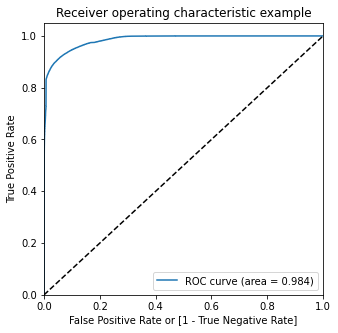


AUC SCORE = 0.984


0.9844591085181568

In [168]:
draw_roc(y_train4, y_train4_pred_prob_svm_grd[:,1])

<br>
We have got the following results from the SVM model on the training set which look very good, with accuracy, sensitivity and precision all near to or above 90%, particularly the precision.

AUC SCORE = 0.984 <br>
ACCURACY :  0.9213157786801197 <br>
SENSITIVITY :  0.8989656781418498 <br>
PRECISION :  0.9747449194704444 <br>

In [169]:
# Get the predictions along with probabilities on the test set
y_test4_pred_svm_grd, y_test4_pred_prob_svm_grd  = predict_and_proba(svm_grd_best_model, X_test4)

In [170]:
# Confusion matrix and evaluation metrics results on Test Data
print_binary_classification_summary(y_test4, y_test4_pred_svm_grd)



Confusion Matrix :

 [[17593   762]
 [ 3198 28447]]

TN : 17593

FP : 762

FN : 3198

TP : 28447

ACCURACY :  0.9208

SENSITIVITY :  0.898941380944857

PRECISION :  0.9739121503646136

FALSE POSITIVITY RATE :  0.04151457368564424

SPECIFICITY :  0.9584854263143557


 Classification Report :

               precision    recall  f1-score   support

           0       0.85      0.96      0.90     18355
           1       0.97      0.90      0.93     31645

    accuracy                           0.92     50000
   macro avg       0.91      0.93      0.92     50000
weighted avg       0.93      0.92      0.92     50000



We have got the following results from the SVM model on the test set which look very good, with accuracy, sensitivity and precision all near to or above 90%, particularly the precision.

ACCURACY :  0.9208

SENSITIVITY :  0.898941380944857

PRECISION :  0.9739121503646136

#### If we compare the above metrics of test data predictions with those obtained from train data predictions, they look almost similar which means our SVM model is able to generalize well
So we will have this model as base-model1 to be part of the stacking ensemble.

In [171]:
base1 = svm_grd_best_model
predictions_base1 = y_test4_pred_svm_grd

In [236]:
import joblib
joblib.dump(base1, "base_model1.pkl")

['base_model1.pkl']

In [149]:
#base1 = joblib.load("base_model1.pkl")
#y_test4_pred_svm_grd, y_test4_pred_prob_svm_grd  = predict_and_proba(base1, X_test4)
#predictions_base1 = y_test4_pred_svm_grd

#### 4.2.1.2 Base Model-2 ( Random Forest Classifier )

##### Build a basic Random Forest Classifier first

In [181]:
from sklearn.ensemble import RandomForestClassifier

In [213]:
#X_train4

In [151]:
X_train4.shape

(121905, 75)

In [184]:
## Train a simple RF model. Use class_weight='balanced' as the dataset has some class imbalance. 
rf1 = RandomForestClassifier(class_weight='balanced')

### Fit on train data
rf1.fit(X_train4, y_train4)

RandomForestClassifier(class_weight='balanced')

In [185]:
# Predict on train set - Get predictions along with probabilities
y_train4_pred_rf1, y_train4_pred_prob_rf1  = predict_and_proba(rf1, X_train4)

In [186]:
# Confusion matrix and key evaluation metrics on Train set results
print_binary_classification_summary(y_train4, y_train4_pred_rf1)



Confusion Matrix :

 [[44698    55]
 [  220 76932]]

TN : 44698

FP : 55

FN : 220

TP : 76932

ACCURACY :  0.9977441450309668

SENSITIVITY :  0.9971484861053505

PRECISION :  0.9992855936716588

FALSE POSITIVITY RATE :  0.001228967890420754

SPECIFICITY :  0.9987710321095793


 Classification Report :

               precision    recall  f1-score   support

           0       1.00      1.00      1.00     44753
           1       1.00      1.00      1.00     77152

    accuracy                           1.00    121905
   macro avg       1.00      1.00      1.00    121905
weighted avg       1.00      1.00      1.00    121905



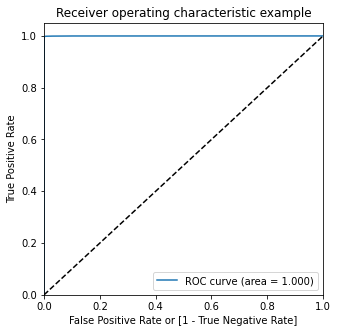


AUC SCORE = 1.000


0.9999285448962717

In [187]:
# ROC curve on Train set results
draw_roc(y_train4, y_train4_pred_prob_rf1[:,1])

##### Metrics look good, so RF can be a good candidate for base model. But AUC of 1 seems to be overfit. 


##### Let us try hyperparameter tuning by using RandomSearchCV first

We try tuning the following hyper-params for Random Forest <br>
max_depth <br>
min_samples_leaf <br>
min_samples_split <br>
n_estimators <br>
max_features <br>

In [188]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

param_grid = {
    'max_depth': [int(x) for x in np.linspace(5,100,20)],
    'min_samples_leaf': [int(x) for x in np.linspace(100,400,4)] ,
    'min_samples_split': [int(x) for x in np.linspace(100,400,4)],
    'n_estimators': [int(x) for x in np.linspace(100,500,5)], 
    'max_features': ['auto', 'sqrt']
}

print(param_grid)

rf_rs = RandomForestClassifier(class_weight='balanced')

scoring_rf_rs = {'Precision':'precision', 'Recall':'recall', 'AUC':'roc_auc'}
refit = 'AUC'

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=100)

random_search_rf =  RandomizedSearchCV(estimator=rf_rs, param_distributions=param_grid, scoring=scoring_rf_rs, 
                                       cv=folds, refit=refit, n_jobs=-1, verbose=10, n_iter=100, random_state=100)

random_results_rf = random_search_rf.fit(X_train4, y_train4)

{'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100], 'min_samples_leaf': [100, 200, 300, 400], 'min_samples_split': [100, 200, 300, 400], 'n_estimators': [100, 200, 300, 400, 500], 'max_features': ['auto', 'sqrt']}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [189]:
# Best hyperparameter set found from random search cv
rf_rand_best_score1 = grid_result_summary(random_results_rf, scoring_rf_rs, refit)

mean_test_AUC

Best hyperparameters:  {'n_estimators': 100, 'min_samples_split': 200, 'min_samples_leaf': 100, 'max_features': 'sqrt', 'max_depth': 65}

Best Score : 0.98207
    mean_test_Precision  mean_test_Recall  mean_test_AUC
18                0.960             0.898          0.982


##### Based on the best hyperparam values found by RandomizedSearchCV, let us use GridSearchCV to further narrow down the optimal hyper-param values

In [190]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [60, 65, 70],
    'min_samples_leaf': [80, 100, 120],
    'min_samples_split': [150, 200, 250],
    'n_estimators': [80, 100, 120] 
}

# Create a base model
rf_grd1 = RandomForestClassifier(class_weight="balanced", max_features='sqrt')

# Use Multi scorer
scoring_measures = {'Precision': 'precision', 'Recall': 'recall', 'AUC' : 'roc_auc'}
refit = 'AUC'

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)


grid_search_rf1 = GridSearchCV(estimator=rf_grd1, param_grid=param_grid, cv=folds, 
                               scoring=scoring_measures, refit=refit, n_jobs=-1, verbose=1)

# Instantiate the grid search model

grid_results_rf1 = grid_search_rf1.fit(X_train4, y_train4)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [191]:
# Best hyperparameter set found from grid search cv
rf_grd_best_score1 = grid_result_summary(grid_results_rf1, scoring_measures, refit)

mean_test_AUC

Best hyperparameters:  {'max_depth': 70, 'min_samples_leaf': 80, 'min_samples_split': 150, 'n_estimators': 120}

Best Score : 0.98295
    mean_test_Precision  mean_test_Recall  mean_test_AUC
56                0.962             0.901          0.983


##### Since best params are from the border values in the earlier grid param options, let us try tuning again.

In [192]:
# Create the parameter grid based on the results of previous grid search 

param_grid = {
    'max_depth': [65, 70, 75],
    'min_samples_leaf': [70, 80, 90],
    'min_samples_split': [125, 150, 175],
    'n_estimators': [100, 120, 140] 
}

# Create a base model
rf_grd2 = RandomForestClassifier(class_weight="balanced", max_features='sqrt')

# Use Multi scorer
scoring_measures = {'Precision': 'precision', 'Recall': 'recall', 'AUC' : 'roc_auc'}
refit = 'AUC'

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# Refit and give the best model based on f1 score. 
grid_search_rf2 = GridSearchCV(estimator=rf_grd2, param_grid=param_grid, cv=folds, 
                               scoring=scoring_measures, refit=refit, n_jobs=-1, verbose=1)

# Instantiate the grid search model
grid_results_rf2 = grid_search_rf2.fit(X_train4, y_train4)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [193]:
# Best hyperparameter set found from grid search cv
rf_grd_best_score2 = grid_result_summary(grid_results_rf2, scoring_measures, refit)

mean_test_AUC

Best hyperparameters:  {'max_depth': 70, 'min_samples_leaf': 70, 'min_samples_split': 125, 'n_estimators': 120}

Best Score : 0.98320
    mean_test_Precision  mean_test_Recall  mean_test_AUC
28                0.962             0.902          0.983


##### Let us stop hyperparameter tuning as we are not seeing any great improvements from the previous gridsearch

In [196]:
# Get the best fit model from latest grid search results
rf_grd_best_model = grid_results_rf2.best_estimator_

In [197]:
# Predictions on train data
y_train4_pred_rf_grd, y_train4_pred_prob_rf_grd  = predict_and_proba(rf_grd_best_model, X_train4)

In [199]:
# Print Confusion matrix and key evaluation metrics on Train set results
print_binary_classification_summary(y_train4, y_train4_pred_rf_grd)



Confusion Matrix :

 [[42660  2093]
 [ 6914 70238]]

TN : 42660

FP : 2093

FN : 6914

TP : 70238

ACCURACY :  0.9261145974324269

SENSITIVITY :  0.9103846951472419

PRECISION :  0.971063582696216

FALSE POSITIVITY RATE :  0.04676781444819342

SPECIFICITY :  0.9532321855518066


 Classification Report :

               precision    recall  f1-score   support

           0       0.86      0.95      0.90     44753
           1       0.97      0.91      0.94     77152

    accuracy                           0.93    121905
   macro avg       0.92      0.93      0.92    121905
weighted avg       0.93      0.93      0.93    121905



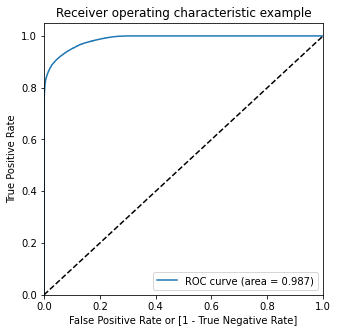


AUC SCORE = 0.987


0.9871380562766459

In [201]:
# Draw ROC curve with predictions on train data
draw_roc(y_train4, y_train4_pred_prob_rf_grd[:,1])

With train set, we have obtained the following metrics with Random Forest model.

AUC SCORE = 0.987 <br>
ACCURACY :  0.9261145974324269 <br>
SENSITIVITY :  0.9103846951472419 <br>
PRECISION :  0.971063582696216 <br>

#### All the key metrics above are above 90% and particularly precision is very good at 97% with the training data. 

Let us see how the RF model fares with the test data.

In [202]:
# Predictions on test set
y_test4_pred_rf_grd, y_test4_pred_prob_rf_grd  = predict_and_proba(rf_grd_best_model, X_test4)

In [204]:
# Print Confusion matrix and key evaluation metrics on Test set results
print_binary_classification_summary(y_test4, y_test4_pred_rf_grd)



Confusion Matrix :

 [[17273  1082]
 [ 3022 28623]]

TN : 17273

FP : 1082

FN : 3022

TP : 28623

ACCURACY :  0.91792

SENSITIVITY :  0.904503081055459

PRECISION :  0.963575155697694

FALSE POSITIVITY RATE :  0.05894851539090166

SPECIFICITY :  0.9410514846090984


 Classification Report :

               precision    recall  f1-score   support

           0       0.85      0.94      0.89     18355
           1       0.96      0.90      0.93     31645

    accuracy                           0.92     50000
   macro avg       0.91      0.92      0.91     50000
weighted avg       0.92      0.92      0.92     50000



With test set, we observe the following metrics with Random Forest model. 

ACCURACY :  0.91792 <br>
SENSITIVITY :  0.904503081055459 <br>
PRECISION :  0.963575155697694 <br>

##### They all appear very close to what was observed with the train set, which means the RF model is able to generalize well

So we will have this model as base-model2 to be part of the stacking ensemble.


In [206]:
base2 = rf_grd_best_model
predictions_base2 = y_test4_pred_rf_grd

In [237]:
joblib.dump(base2, "base_model2.pkl")

['base_model2.pkl']

In [152]:
#base2 = joblib.load("base_model2.pkl")
#y_test4_pred_rf_grd, y_test4_pred_prob_rf_grd  = predict_and_proba(base2, X_test4)
#predictions_base2 = y_test4_pred_rf_grd

#### 4.2.1.3 Base Model-3 (XGBoost Classifier)

##### Let us train a basic XGB classifier

In [214]:
from xgboost import XGBClassifier

In [154]:
y_train4.value_counts()

1    77152
0    44753
Name: label, dtype: int64

In [155]:
# Find the ratio of negative class to positive class, this ratio will be passed as scale_pos_weight
# to XGB to address class imbalance
y_train4.value_counts()[0] / y_train4.value_counts()[1]

0.5800627333056823

In [32]:
# Train XGB. Set scale_pos_weight.
xgbm = XGBClassifier(scale_pos_weight=0.58,  tree_method='gpu_hist', eval_metric='logloss')

xgbm.fit(X_train4, y_train4)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.58, subsample=1,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [33]:
# Predictions on train set
y_train4_pred_xgb, y_train4_pred_prob_xgb  = predict_and_proba(xgbm, X_train4)

In [34]:
# Print confusion matrix and key classification metrics from prediction results on train set.
print_binary_classification_summary(y_train4, y_train4_pred_xgb)



Confusion Matrix :

 [[43683  1070]
 [ 4620 72532]]

TN : 43683

FP : 1070

FN : 4620

TP : 72532

ACCURACY :  0.9533243099134572

SENSITIVITY :  0.94011820821236

PRECISION :  0.9854623515665335

FALSE POSITIVITY RATE :  0.023909011686367394

SPECIFICITY :  0.9760909883136326


 Classification Report :

               precision    recall  f1-score   support

           0       0.90      0.98      0.94     44753
           1       0.99      0.94      0.96     77152

    accuracy                           0.95    121905
   macro avg       0.94      0.96      0.95    121905
weighted avg       0.96      0.95      0.95    121905



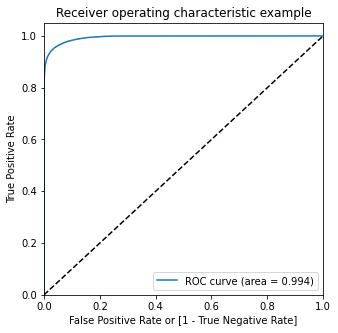


AUC SCORE = 0.994


0.9944393842693389

In [35]:
# ROC curve on train set predictions
draw_roc(y_train4, y_train4_pred_prob_xgb[:,1])

##### Accuracy, Sensitivity, Precision etc look very good. AUC score is very close to 1. XGB looks a good candidate for base model.

##### Let us try hyperparameter tuning by using RandomSearchCV first.

We try tuning the following hyper-params for XGBoost <br>
max_depth <br>
learning_rate <br>
n_estimators <br>
subsample <br>


In [36]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

# creating a KFold object 
folds = StratifiedKFold(n_splits = 3, shuffle = True, random_state=100)


# specify range of hyperparameters
param_grid = {
             'max_depth': [5,7,9,11,13,15],
             'learning_rate': [0.025, 0.05, 0.075, 0.10],
             'n_estimators':  [int(x) for x in np.linspace(100,500,5)],
             'subsample': [float(x) for x in np.linspace(0.1, 1, 10)]
             }          

print(param_grid)

# Use Multi scorer
scoring_measures = {'Precision': 'precision', 'Recall': 'recall', 'AUC' : 'roc_auc'}
refit = 'AUC'

# specify model
xgb_model_rdm = XGBClassifier(random_state=123, tree_method='gpu_hist', scale_pos_weight=0.58, eval_metric='logloss')

random_search_xgb = RandomizedSearchCV(estimator=xgb_model_rdm, param_distributions=param_grid, scoring=scoring_measures, 
                                       cv=folds, refit=refit, verbose=1, n_iter=50)

# fit the model
random_results_xgb = random_search_xgb.fit(X_train4, y_train4)

{'max_depth': [5, 7, 9, 11, 13, 15], 'learning_rate': [0.025, 0.05, 0.075, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'subsample': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9, 1.0]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [37]:
## Print the results of random search 
xgb_rand_best_score = grid_result_summary(random_results_xgb, scoring_measures, refit)

mean_test_AUC

Best hyperparameters:  {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 15, 'learning_rate': 0.025}

Best Score : 0.98609
   mean_test_Precision  mean_test_Recall  mean_test_AUC
9             0.953309          0.932562       0.986089


##### Based on the best hyperparam values found by RandomizedSearchCV, let us use GridSearchCV to further narrow down the optimal hyper-param values.

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
# creating a KFold object 
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state=100)


# specify range of hyperparameters

### Due to computational constraints, we omit gamma and n_estimators from gridsearch.
param_grid = {
             'max_depth': [13, 15, 17],
             'learning_rate': [0.01, 0.025, 0.05],
             'subsample': [0.4, 0.5, 0.6, 0.7],
             'min_child_weight': [0.10, 0.20, 0.30]
             #'gamma': np.arange(0.0,40.0,0.005),
             }      

#print(param_grid)

# Use Multi scorer
scoring_measures = {'Precision': 'precision', 'Recall': 'recall', 'AUC' : 'roc_auc'}
refit = 'AUC'

# specify model

xgb_model_grd = XGBClassifier(random_state=123, 
                          scale_pos_weight=0.58, 
                          tree_method='gpu_hist', 
                          eval_metric='logloss', 
                          n_estimators=500) 


# set up GridSearchCV()
grid_search_xgb = GridSearchCV(estimator = xgb_model_grd, 
                       param_grid = param_grid, 
                       scoring = scoring_measures, 
                       refit=refit,
                       cv = folds, 
                       verbose = 1)    

# fit the model
grid_results_xgb = grid_search_xgb.fit(X_train4, y_train4) 


Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [39]:
## Print the results of grid search 
xgb_grd_best_score = grid_result_summary(grid_results_xgb, scoring_measures, refit)

mean_test_AUC

Best hyperparameters:  {'learning_rate': 0.025, 'max_depth': 13, 'min_child_weight': 0.1, 'subsample': 0.7}

Best Score : 0.98666
    mean_test_Precision  mean_test_Recall  mean_test_AUC
39             0.955828          0.933093       0.986663


In [40]:
# Get the best fit model
xgb_grd_best_model = grid_results_xgb.best_estimator_

In [41]:
# Predictions on train data
y_train4_pred_xgb_grd, y_train4_pred_prob_xgb_grd  = predict_and_proba(xgb_grd_best_model, X_train4)

In [42]:
# Print the confusion matrix and key classification metrics on train set predictions
print_binary_classification_summary(y_train4, y_train4_pred_xgb_grd)



Confusion Matrix :

 [[44635   118]
 [  966 76186]]

TN : 44635

FP : 118

FN : 966

TP : 76186

ACCURACY :  0.9911078298675198

SENSITIVITY :  0.9874792617171299

PRECISION :  0.9984535542042356

FALSE POSITIVITY RATE :  0.00263669474672089

SPECIFICITY :  0.9973633052532791


 Classification Report :

               precision    recall  f1-score   support

           0       0.98      1.00      0.99     44753
           1       1.00      0.99      0.99     77152

    accuracy                           0.99    121905
   macro avg       0.99      0.99      0.99    121905
weighted avg       0.99      0.99      0.99    121905



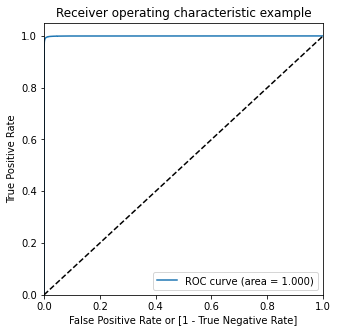


AUC SCORE = 1.000


0.9997812984771206

In [43]:
# ROC curve on train set predictions
draw_roc(y_train4, y_train4_pred_prob_xgb_grd[:,1])

##### With train set, we observe the following metrics with XGBoost model. 

ACCURACY :  0.9911078298675198 <br>

SENSITIVITY :  0.9874792617171299 <br>

PRECISION :  0.9984535542042356 <br>

The metrics does seem very high, accuracy, sensitivity and precision all above 98%. 

##### Let us check the prediction results on test set to see if it is a overfit case or a very robust model

In [45]:
# Predictions on test set
y_test4_pred_xgb_grd, y_test4_pred_prob_xgb_grd  = predict_and_proba(xgb_grd_best_model, X_test4)

In [46]:
# Print the confusion matrix and key classification metrics on train set predictions
print_binary_classification_summary(y_test4, y_test4_pred_xgb_grd)



Confusion Matrix :

 [[17038  1317]
 [ 2152 29493]]

TN : 17038

FP : 1317

FN : 2152

TP : 29493

ACCURACY :  0.93062

SENSITIVITY :  0.9319955759203665

PRECISION :  0.9572541382667965

FALSE POSITIVITY RATE :  0.07175156633070008

SPECIFICITY :  0.9282484336692999


 Classification Report :

               precision    recall  f1-score   support

           0       0.89      0.93      0.91     18355
           1       0.96      0.93      0.94     31645

    accuracy                           0.93     50000
   macro avg       0.92      0.93      0.93     50000
weighted avg       0.93      0.93      0.93     50000



##### With test set, we observe the following metrics with XGBoost model. 

ACCURACY :  0.93062 <br>

SENSITIVITY :  0.9319955759203665 <br>

PRECISION :  0.9572541382667965 <br>
    
The metrics look very good - accuracy, sensitivity and precision all above 93%.

##### So this XGBoost model performs well on test set also and can be taken as one of the base models in the stacking ensemble.

In [47]:
base3 = xgb_grd_best_model
predictions_base3 = y_test4_pred_xgb_grd

In [51]:
joblib.dump(base3, 'base_model3.pkl')

['base_model3.pkl']

In [157]:
#base3 = joblib.load('base_model3.pkl')
#y_test4_pred_xgb_grd, y_test4_pred_prob_xgb_grd  = predict_and_proba(base3, X_test4)
#predictions_base3 = y_test4_pred_xgb_grd

### 4.2.2 Stacking Blender Model (Logistic Regression Classifier)

In [158]:
## Check the length of predictions of base models, which we will use for training the blender model.
len(predictions_base1)

50000

In [159]:
len(predictions_base2)

50000

In [160]:
len(predictions_base3)

50000

##### Combine the base model predictions as the new feature set, for training and testing the blender model

In [162]:
# The predictions of the three individual base models will be the features for training the Stacking blender.
### So, stack together the three predictions in to a single 3D vector for each input data record.

X_test4_base_predictions = np.column_stack((predictions_base1, predictions_base2, predictions_base3))
X_train5 = X_test4_base_predictions 
y_train5 = y_test4

# X_test3 was previously set aside for testing the stacking blender. Get the base model predictions for that to 
# input those to blender to test.
y_test3_pred_base1, y_test3_pred_prob_base1  = predict_and_proba(base1, X_test3)
y_test3_pred_base2, y_test3_pred_prob_base2  = predict_and_proba(base2, X_test3)
y_test3_pred_base3, y_test3_pred_prob_base3  = predict_and_proba(base3, X_test3)

X_test3_base_predictions = np.column_stack((y_test3_pred_base1, y_test3_pred_base2, y_test3_pred_base3))
X_test5 = X_test3_base_predictions 
y_test5 = y_test3

In [163]:
X_train5.shape, y_train5.shape, X_test5.shape, y_test5.shape

((50000, 3), (50000,), (30000, 3), (30000,))

In [221]:
print(X_train5)
print()
print(X_test5)

[[1 1 1]
 [1 1 1]
 [1 1 1]
 ...
 [0 0 0]
 [1 1 1]
 [1 1 1]]

[[0 0 0]
 [1 1 1]
 [1 1 1]
 ...
 [1 1 1]
 [1 1 1]
 [0 0 0]]


In [227]:
print(y_train5[:5])
print()
print(y_test5[:5])

89166     1
21632     1
239770    1
143220    1
125048    1
Name: label, dtype: int32

30765     0
125310    1
222323    1
95680     1
116781    0
Name: label, dtype: int32


##### Build a Logistic Regression model and fit on the predictions of the base models

In [165]:
from sklearn.linear_model import LogisticRegression
lr_blender = LogisticRegression(class_weight='balanced')

In [166]:
lr_blender.fit(X_train5, y_train5)

LogisticRegression(class_weight='balanced')

In [167]:
# Get the predictions of the blender on the train set
y_train5_pred_blend, y_train5_pred_prob_blend  = predict_and_proba(lr_blender, X_train5)

In [168]:
# Print confusion matrix and key classification metric values for the train set predictions
print_binary_classification_summary(y_train5, y_train5_pred_blend)



Confusion Matrix :

 [[17417   938]
 [ 2816 28829]]

TN : 17417

FP : 938

FN : 2816

TP : 28829

ACCURACY :  0.92492

SENSITIVITY :  0.9110127982303682

PRECISION :  0.9684885947525783

FALSE POSITIVITY RATE :  0.05110324162353582

SPECIFICITY :  0.9488967583764641


 Classification Report :

               precision    recall  f1-score   support

           0       0.86      0.95      0.90     18355
           1       0.97      0.91      0.94     31645

    accuracy                           0.92     50000
   macro avg       0.91      0.93      0.92     50000
weighted avg       0.93      0.92      0.93     50000



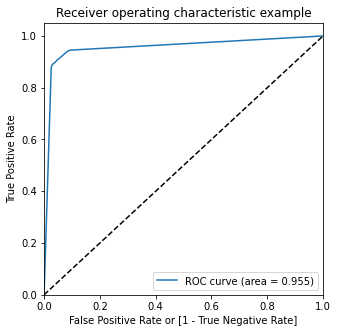


AUC SCORE = 0.955


0.955163086610307

In [169]:
# ROC curve for the train set predictions
draw_roc(y_train5, y_train5_pred_prob_blend[:,1])

#### We observe the following evaluation metric values on the train set

AUC SCORE = 0.955

ACCURACY :  0.92492

SENSITIVITY :  0.9110127982303682

PRECISION :  0.9684885947525783
    
##### All the key metrics values including sensitivity are above 90% and precision is very good at 96.8%. This is very good and indicates that the LR blender does a very good job in final predictions on train set.


##### Let us test the blender with it's test set


In [170]:
# Predictions on the test set
y_test5_pred_blend, y_test5_pred_prob_blend  = predict_and_proba(lr_blender, X_test5)

In [171]:
# Print confusion matrix and key classification metric values for the test set predictions
print_binary_classification_summary(y_test5, y_test5_pred_blend)



Confusion Matrix :

 [[10401   612]
 [ 1679 17308]]

TN : 10401

FP : 612

FN : 1679

TP : 17308

ACCURACY :  0.9236333333333333

SENSITIVITY :  0.9115710749460157

PRECISION :  0.9658482142857143

FALSE POSITIVITY RATE :  0.05557068918550804

SPECIFICITY :  0.944429310814492


 Classification Report :

               precision    recall  f1-score   support

           0       0.86      0.94      0.90     11013
           1       0.97      0.91      0.94     18987

    accuracy                           0.92     30000
   macro avg       0.91      0.93      0.92     30000
weighted avg       0.93      0.92      0.92     30000



#### We observe the following evaluation metric values on the train set

ACCURACY :  0.9236333333333333

SENSITIVITY :  0.9115710749460157

PRECISION :  0.9658482142857143

##### All the key metrics values including sensitivity are above 90% and precision is very good at 96.5%. This is very similar to the results on train set and indicates that the LR blender does a very good job in generalization and final predictions on test set.

# 5. Final Whole Model Validation 

#### Test finally the whole model pipeline with X_test1 set aside previously

The procedure will be as follows.

1. Pass the test data to the trained Autoencoder to get the feature extractions.
2. Pass the features extracted, separately to each of the three base models trained so far. 
   Get the predictions (normal/attack) from each base model. It will be label 0 or 1.
3. Stack together the predictions from each of the three base models, in to a 3D feature vector.
4. Pass this new feature set finally to the stacking blender to get the final classification prediction.
5. Validate the results using standard classification metrics and confusion matrix.



In [172]:
X_test1.shape

(30000, 192)

In [173]:
X_test1

array([[-0.62209643, -0.43169889, -0.3222141 , ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       [-0.62209643, -0.43169889, -0.3222141 , ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       [-0.4084536 ,  0.48085395,  0.11347547, ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       ...,
       [-0.62210931, -0.43169889, -0.3222141 , ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       [-0.62210416, -0.43169889, -0.3222141 , ..., -0.08674712,
        -0.01780678, -0.0022255 ],
       [-0.61935012, -0.43169889, -0.25997273, ..., -0.08674712,
        -0.01780678, -0.0022255 ]])

#### Pass the test data to the trained Autoencoder, to get the feature extractions.

In [174]:
X_test1_AE_encodings = stacked_encoder.predict(X_test1)

In [175]:
X_test1_AE_encodings.shape

(30000, 75)

In [176]:
X_test1_AE_encodings

array([[ 0.5138482 ,  1.1586665 , -1.4243598 , ..., -0.68094534,
         0.41030177,  0.3592629 ],
       [ 0.50728583,  1.0989724 , -1.42438   , ..., -0.5968498 ,
         0.44042745,  0.33662507],
       [-1.3518404 , -1.247841  , -0.925708  , ...,  0.48217323,
         0.54721713, -1.0700496 ],
       ...,
       [ 0.38996333,  1.1446431 , -1.4798985 , ...,  0.1321939 ,
         0.53201187,  0.47879806],
       [10.292419  ,  0.587174  ,  3.0315006 , ...,  4.557115  ,
        -1.4975767 , -0.8466593 ],
       [-0.85561603,  0.3667158 , -1.2281933 , ...,  0.73536325,
         0.7157045 , -0.8397492 ]], dtype=float32)

In [177]:
joblib.dump(X_test1_AE_encodings, 'X_test1_AE_encodings.pkl')

['X_test1_AE_encodings.pkl']

In [178]:
#X_test1_AE_encodings = joblib.load('X_test1_AE_encodings.pkl')

#### Pass the features extracted, separately to each of the three base models trained so far. Get the predictions (normal/attack) from each base model. 

In [179]:
y_test1_pred_base1, y_test1_pred_prob_base1  = predict_and_proba(base1, X_test1_AE_encodings)

In [180]:
y_test1_pred_base2, y_test1_pred_prob_base2  = predict_and_proba(base2, X_test1_AE_encodings)

In [181]:
y_test1_pred_base3, y_test1_pred_prob_base3  = predict_and_proba(base3, X_test1_AE_encodings)

#### Stack together the predictions from each of the three base models, in to a 3D feature vector.

In [182]:
X_test1_base_predictions = np.column_stack((y_test1_pred_base1, y_test1_pred_base2, y_test1_pred_base3))

#### Pass this new feature set finally to the stacking blender to get the final classification prediction.

In [183]:
y_test1_pred_blender, y_test1_pred_prob_blender  = predict_and_proba(lr_blender, X_test1_base_predictions)

#### Validate the results using standard classification metrics and confusion matrix.

In [184]:
print_binary_classification_summary(y_test1, y_test1_pred_blender)



Confusion Matrix :

 [[10455   558]
 [ 1652 17335]]

TN : 10455

FP : 558

FN : 1652

TP : 17335

ACCURACY :  0.9263333333333333

SENSITIVITY :  0.9129931005424764

PRECISION :  0.9688146202425529

FALSE POSITIVITY RATE :  0.050667393080904385

SPECIFICITY :  0.9493326069190956


 Classification Report :

               precision    recall  f1-score   support

           0       0.86      0.95      0.90     11013
           1       0.97      0.91      0.94     18987

    accuracy                           0.93     30000
   macro avg       0.92      0.93      0.92     30000
weighted avg       0.93      0.93      0.93     30000





ACCURACY :  0.9263333333333333

SENSITIVITY :  0.9129931005424764

PRECISION :  0.9688146202425529

All the key metrics values including sensitivity are above 91% and precision is very good at around 97%. 

#### The final whole model (Auto encoder and Stacking)  does a very good job in final predictions on test set. FPR is also very low at just 5% 

# 6. Conclusion

### The final whole model (Auto encoder and Stacking ensemble) does a very good job in final predictions on test set. FPR is also very low at just 5%